In [1]:
%pip install torch pandas sentence-transformers tqdm lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# Load multilingual SBERT model (MPNet backbone, supports Slovene)
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
model.eval()

# Load your dataset
df = pd.read_json("rtvslo_validation.json")  # assumes a list of article dicts

df['full_text'] = df['title'] + " " + df['lead'] + " " + df['paragraphs'].apply(lambda x: " ".join(x))

# Encode all articles
embeddings = []
for text in tqdm(df['full_text']):
    emb = model.encode(text, convert_to_tensor=True)  # returns a torch.Tensor
    embeddings.append(emb)

# Stack into one tensor
embeddings_tensor = torch.stack(embeddings)
torch.save(embeddings_tensor, "text_embeddings_val.pt")

# Also save the targets
targets = torch.tensor(df['n_comments'].values, dtype=torch.float32)
torch.save(targets, "targets_val.pt")


100%|██████████| 2218/2218 [00:38<00:00, 57.32it/s]


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Slovene SloBERTa model
tokenizer = AutoTokenizer.from_pretrained("EMBEDDIA/sloberta")
model = AutoModel.from_pretrained("EMBEDDIA/sloberta").to(device)
model.eval()

# Load dataset
df = pd.read_json("rtvslo_test.json")
df['full_text'] = df['title'] + " " + df['lead'] + " " + df['paragraphs'].apply(lambda x: " ".join(x))

# Optional: Mean pooling function
def mean_pooling(outputs, attention_mask):
    token_embeddings = outputs.last_hidden_state  # (batch, seq_len, hidden)
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, dim=1) / \
           torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)

# Function to embed a single article using mean pooling
def embed_article(text):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=512,
        return_token_type_ids=False
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        pooled = mean_pooling(outputs, inputs['attention_mask'])
    return pooled.squeeze(0)

# Embed all articles
embeddings = []
for text in tqdm(df['full_text']):
    emb = embed_article(text)
    embeddings.append(emb.cpu())  # move back to CPU to stack later

# Stack and save embeddings
embeddings_tensor = torch.stack(embeddings)
torch.save(embeddings_tensor, "sloberta_embeddings_final.pt")


Some weights of CamembertModel were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2218/2218 [01:16<00:00, 29.01it/s]


In [ ]:
# --- 1. Imports ---
import json
import numpy as np
import pandas as pd
import torch
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error

# --- 2. Utility Functions ---
def load_json(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_topics_subtopics(articles):
    topics, subtopics = [], []
    for a in articles:
        parts = a['url'].split('/')
        topic = parts[3] if len(parts) > 3 else 'none'
        subtopic = parts[4] if len(parts) > 4 else 'none'
        topics.append(topic)
        subtopics.append(subtopic if subtopic != "NO_SUBTOPIC" else "none")
    return topics, subtopics

def enrich_articles(articles):
    for a in articles:
        dt = pd.to_datetime(a['date'])
        a['year'] = dt.year
        a['month'] = dt.month
        a['day_of_week'] = dt.weekday()
        a['hour'] = dt.hour
    return articles

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    date_feats = np.concatenate([years_scaled, months_scaled, day_sin[:, None], day_cos[:, None], hour_sin[:, None], hour_cos[:, None]], axis=1)
    return date_feats

def prepare_features(articles, bert_reduced, topic_enc=None, subtopic_enc=None, fit_encoders=False):
    topics, subtopics = extract_topics_subtopics(articles)

    if fit_encoders:
        topic_enc = LabelEncoder().fit(topics)
        subtopic_enc = LabelEncoder().fit(subtopics)

    topics = [t if t in topic_enc.classes_ else topic_enc.classes_[0] for t in topics]
    subtopics = [s if s in subtopic_enc.classes_ else subtopic_enc.classes_[0] for s in subtopics]

    topic_ids = topic_enc.transform(topics)
    subtopic_ids = subtopic_enc.transform(subtopics)

    time_feats = process_date_features(articles)

    features = np.hstack([bert_reduced, topic_ids[:, None], subtopic_ids[:, None], time_feats])
    return features, topic_enc, subtopic_enc

def train_lightgbm(X_train, y_train, X_val, y_val, weights_train, weights_val):
    params = {
        'objective': 'quantile',     # quantile regression (median)
        'alpha': 0.5,                # 0.5 = median
        'learning_rate': 0.05,
        'num_leaves': 128,
        'max_depth': -1,
        'min_data_in_leaf': 30,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'device_type': 'cpu',
        'verbosity': -1,
        'seed': 42
    }

    train_set = lgb.Dataset(X_train, label=y_train, weight=weights_train)
    val_set = lgb.Dataset(X_val, label=y_val, weight=weights_val)

    model = lgb.train(
        params,
        train_set,
        valid_sets=[train_set, val_set],
        valid_names=['train', 'valid'],
        num_boost_round=5000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100)
        ]
    )

    return model

def calibrate_predictions(preds, train_targets_sorted, pred_train_sorted):
    """Postprocessing: Match percentiles between train and predictions."""
    ranks = np.searchsorted(pred_train_sorted, preds, side='left') / len(pred_train_sorted)
    calibrated = np.quantile(train_targets_sorted, ranks)
    return calibrated

# --- 3. Load and Prepare Data ---
print("🔵 Loading data...")
train_articles = load_json("rtvslo_train.json")
val_articles = load_json("rtvslo_validation.json")

train_articles = enrich_articles(train_articles)
val_articles = enrich_articles(val_articles)

bert_train = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()
bert_val = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()

# --- 4. Dimensionality Reduction ---
print("🔵 Running PCA...")
pca_model = PCA(n_components=50, random_state=42)
bert_train_reduced = pca_model.fit_transform(bert_train)
bert_val_reduced = pca_model.transform(bert_val)

print(f"✅ PCA done. Shape: {bert_train_reduced.shape}")

# --- 5. Prepare Features
print("🔵 Preparing features...")
X_train, topic_enc, subtopic_enc = prepare_features(train_articles, bert_train_reduced, fit_encoders=True)
X_val, _, _ = prepare_features(val_articles, bert_val_reduced, topic_enc, subtopic_enc)

y_train_raw = np.array([a['n_comments'] for a in train_articles], dtype=np.float32)
np.savetxt("train_targets.txt", y_train_raw, fmt="%.4f")

y_val_raw = np.array([a['n_comments'] for a in val_articles], dtype=np.float32)

y_train = np.log1p(y_train_raw)
y_val = np.log1p(y_val_raw)

# Weights: higher for larger original n_comments
weights_train = np.sqrt(y_train_raw + 1)
weights_val = np.sqrt(y_val_raw + 1)

# --- 6. Train LightGBM
print("🔵 Training LightGBM...")
model = train_lightgbm(X_train, y_train, X_val, y_val, weights_train, weights_val)

# --- 7. Predict
print("🔵 Predicting...")
val_preds = model.predict(X_val, num_iteration=model.best_iteration)

# Undo log1p
val_preds_exp = np.clip(np.expm1(val_preds), 0, None)

# --- 8. Postprocessing Calibration
print("🔵 Calibrating predictions...")
pred_train = model.predict(X_train, num_iteration=model.best_iteration)
train_preds_exp = np.clip(np.expm1(pred_train), 0, None)

train_targets_sorted = np.sort(y_train_raw)
pred_train_sorted = np.sort(train_preds_exp)

val_preds_calibrated = calibrate_predictions(val_preds_exp, train_targets_sorted, pred_train_sorted)

# --- 9. Save and Evaluate
print("🔵 Saving predictions...")
np.savetxt("predictions_val_raw.txt", val_preds_exp, fmt="%.4f")
np.savetxt("predictions_val_calibrated.txt", val_preds_calibrated, fmt="%.4f")

print("🔵 Evaluating...")
mae_raw = mean_absolute_error(y_val_raw, val_preds_exp)
mae_calibrated = mean_absolute_error(y_val_raw, val_preds_calibrated)

print(f"✅ MAE Raw          : {mae_raw:.4f}")
print(f"✅ MAE Calibrated   : {mae_calibrated:.4f}")


🔵 Loading data...
🔵 Running PCA...
✅ PCA done. Shape: (46830, 50)
🔵 Preparing features...
🔵 Training LightGBM...
Training until validation scores don't improve for 100 rounds
[100]	train's quantile: 0.312468	valid's quantile: 0.391089
[200]	train's quantile: 0.268099	valid's quantile: 0.37803
[300]	train's quantile: 0.248439	valid's quantile: 0.375506
[400]	train's quantile: 0.237404	valid's quantile: 0.373446
[500]	train's quantile: 0.229766	valid's quantile: 0.372943
[600]	train's quantile: 0.222879	valid's quantile: 0.372449
[700]	train's quantile: 0.217853	valid's quantile: 0.371897
[800]	train's quantile: 0.212485	valid's quantile: 0.372245
Early stopping, best iteration is:
[767]	train's quantile: 0.214405	valid's quantile: 0.371737
🔵 Predicting...
🔵 Calibrating predictions...
🔵 Saving predictions...
🔵 Evaluating...
✅ MAE Raw          : 29.9895
✅ MAE Calibrated   : 28.9768


In [8]:
# --- 1. Imports ---
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from tqdm import tqdm

# --- 2. Utility Functions ---
def load(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    date_feats = np.concatenate([years_scaled, months_scaled, day_sin[:, None], day_cos[:, None], hour_sin[:, None], hour_cos[:, None]], axis=1)
    return date_feats

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

# --- 3. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, bert_vectors, topic_ids, subtopic_ids, date_feats, targets):
        self.X = bert_vectors
        self.topic_ids = topic_ids
        self.subtopic_ids = subtopic_ids
        self.date_feats = date_feats
        self.y = targets

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.y[idx]

# --- 4. Model ---
class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)

        self.model = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats], dim=1)
        return self.model(x)

# --- 5. Main Trainer Class ---
class RTVSloBERT:
    def __init__(self, batch_size=170, epochs=70, learning_rate=1e-4, l2_lambda=1e-3, eval_split=0.05, model_id=0):
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.eval_split = eval_split
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_id = model_id

    def fit(self, train_data):
        for a in train_data:
            dt = pd.to_datetime(a['date'])
            a['year'] = dt.year
            a['month'] = dt.month
            a['day_of_week'] = dt.weekday()
            a['hour'] = dt.hour

        raw_targets = [a['n_comments'] for a in train_data]
        targets = [np.log1p(t) for t in raw_targets]
        bert_vectors = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()

        topics = []
        subtopics = []
        for a in train_data:
            topic, subtopic = extract_topics_from_url(a['url'])
            topics.append(topic)
            subtopics.append(subtopic if subtopic != "NO_SUBTOPIC" else "none")

        date_feats = process_date_features(train_data)

        self.topic_encoder = LabelEncoder().fit(topics)
        self.subtopic_encoder = LabelEncoder().fit(subtopics)

        topic_ids = self.topic_encoder.transform(topics)
        subtopic_ids = self.subtopic_encoder.transform(subtopics)

        X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, y_train, y_val = train_test_split(
            bert_vectors, topic_ids, subtopic_ids, date_feats, targets, test_size=self.eval_split, random_state=42
        )

        train_dataset = NewsDataset(
            torch.tensor(X_train, dtype=torch.float32).to(self.device),
            torch.tensor(topic_train, dtype=torch.long).to(self.device),
            torch.tensor(subtopic_train, dtype=torch.long).to(self.device),
            torch.tensor(date_train, dtype=torch.float32).to(self.device),
            torch.tensor(y_train, dtype=torch.float32).to(self.device)
        )
        val_dataset = NewsDataset(
            torch.tensor(X_val, dtype=torch.float32).to(self.device),
            torch.tensor(topic_val, dtype=torch.long).to(self.device),
            torch.tensor(subtopic_val, dtype=torch.long).to(self.device),
            torch.tensor(date_val, dtype=torch.float32).to(self.device),
            torch.tensor(y_val, dtype=torch.float32).to(self.device)
        )

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

        input_dim = bert_vectors.shape[1]
        self.model = MLPWithEmbeddings(input_dim, len(self.topic_encoder.classes_), len(self.subtopic_encoder.classes_)).to(self.device)

        self._train(self.model, train_loader, val_loader)

    def _train(self, model, train_loader, val_loader):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate, weight_decay=self.l2_lambda)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        criterion = nn.HuberLoss(delta=5.0)

        best_val_mae = float('inf')
        best_model_state = None

        for epoch in range(self.epochs):
            model.train()
            for x_batch, topic_ids, subtopic_ids, date_feats, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(x_batch, topic_ids, subtopic_ids, date_feats).squeeze()
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

            model.eval()
            val_losses = []
            with torch.no_grad():
                for x_batch, topic_ids, subtopic_ids, date_feats, y_batch in val_loader:
                    y_pred = model(x_batch, topic_ids, subtopic_ids, date_feats).squeeze()
                    loss = criterion(y_pred, y_batch)
                    val_losses.append(loss.item())

            val_loss = np.mean(val_losses)
            scheduler.step(val_loss)

            if val_loss < best_val_mae:
                best_val_mae = val_loss
                best_model_state = model.state_dict()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{self.epochs} - Validation loss: {val_loss:.4f}")

        # Save snapshot
        os.makedirs("snapshots", exist_ok=True)
        torch.save(best_model_state, f"snapshots/model_{self.model_id:03d}.pt")

    def predict(self, test_data, bert_vectors):
        for a in test_data:
            dt = pd.to_datetime(a['date'])
            a['year'] = dt.year
            a['month'] = dt.month
            a['day_of_week'] = dt.weekday()
            a['hour'] = dt.hour

        topics = []
        subtopics = []
        for a in test_data:
            topic, subtopic = extract_topics_from_url(a['url'])
            topics.append(topic)
            subtopics.append(subtopic if subtopic != "NO_SUBTOPIC" else "none")

        date_feats = process_date_features(test_data)

        topic_ids = [self.topic_encoder.classes_[0] if t not in self.topic_encoder.classes_ else t for t in topics]
        subtopic_ids = [self.subtopic_encoder.classes_[0] if s not in self.subtopic_encoder.classes_ else s for s in subtopics]

        topic_ids = self.topic_encoder.transform(topic_ids)
        subtopic_ids = self.subtopic_encoder.transform(subtopic_ids)

        X = torch.tensor(bert_vectors, dtype=torch.float32).to(self.device)
        topic_ids = torch.tensor(topic_ids, dtype=torch.long).to(self.device)
        subtopic_ids = torch.tensor(subtopic_ids, dtype=torch.long).to(self.device)
        date_feats = torch.tensor(date_feats, dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(X, topic_ids, subtopic_ids, date_feats).squeeze().cpu().numpy()
            return np.clip(np.expm1(preds), 0, None)

# --- 6. Main Loop (Ensemble 70×) ---
if __name__ == '__main__':
    train = load("rtvslo_train.json")
    validation = load("rtvslo_validation.json")
    test = load("rtvslo_test.json")

    bert_vectors_validation = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()
    bert_vectors_test = torch.load("sloberta_embeddings_final.pt", map_location="cpu").numpy()

    preds_validation = []
    preds_test = []

    for seed in range(20):
        print(f"\n🚀 Training model {seed+1}/70...")
        model = RTVSloBERT(model_id=seed)
        model.fit(train)

        val_preds = model.predict(validation, bert_vectors_validation)
        test_preds = model.predict(test, bert_vectors_test)

        preds_validation.append(val_preds)
        preds_test.append(test_preds)

    # Average all predictions
    final_val_preds = np.median(preds_validation, axis=0)
    final_test_preds = np.median(preds_test, axis=0)

    np.savetxt("final_predictions_val.txt", final_val_preds, fmt="%.4f")
    np.savetxt("final_predictions_test.txt", final_test_preds, fmt="%.4f")

    print("✅ Done!")



🚀 Training model 1/70...


KeyboardInterrupt: 

In [ ]:
# --- 1. Imports ---
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
import pandas as pd
from tqdm import tqdm

# --- 2. Utility Functions ---
def load(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    date_feats = np.concatenate(
        [years_scaled, months_scaled, day_sin[:, None], day_cos[:, None], hour_sin[:, None], hour_cos[:, None]],
        axis=1
    )
    return date_feats

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

def extract_semantic_flags(articles):
    flags = []
    for a in articles:
        url = a.get('url', '').lower()
        is_politics = any(word in url for word in ['politics', 'elections', 'parliament', 'vlada', 'politika'])
        is_ukraine_russia = any(word in url for word in ['ukraine', 'russia', 'ukrajina', 'rusija'])
        is_israel_palestine = any(word in url for word in ['israel', 'palestine', 'gaza', 'hamas'])
        is_sport = any(word in url for word in ['sport', 'nogomet', 'košarka', 'tenis', 'hokej'])
        flags.append([is_politics, is_ukraine_russia, is_israel_palestine, is_sport])
    return np.array(flags, dtype=np.float32)

# --- 3. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, X, topic_ids, subtopic_ids, date_feats, semantic_flags, targets):
        self.X = X
        self.topic_ids = topic_ids
        self.subtopic_ids = subtopic_ids
        self.date_feats = date_feats
        self.semantic_flags = semantic_flags
        self.y = targets

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.semantic_flags[idx], self.y[idx]

# --- 4. Model ---
class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)

        self.model = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6 + 4, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats, semantic_flags):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats, semantic_flags], dim=1)
        return self.model(x)

# --- 5. Main Trainer ---
class RTVSloBERT:
    def __init__(self, batch_size=170, epochs=70, learning_rate=1e-4, l2_lambda=1e-3, eval_split=0.05):
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.eval_split = eval_split
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, train_data, save_dir="snapshots"):
        os.makedirs(save_dir, exist_ok=True)

        for a in train_data:
            dt = pd.to_datetime(a['date'])
            a['year'] = dt.year
            a['month'] = dt.month
            a['day_of_week'] = dt.weekday()
            a['hour'] = dt.hour

        raw_targets = np.array([a['n_comments'] for a in train_data])
        targets = np.log1p(raw_targets)

        bert_vectors = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()

        topics = []
        subtopics = []
        for a in train_data:
            topic, subtopic = extract_topics_from_url(a['url'])
            topics.append(topic)
            subtopics.append(subtopic if subtopic != "NO_SUBTOPIC" else "none")

        date_feats = process_date_features(train_data)
        semantic_flags = extract_semantic_flags(train_data)

        self.topic_encoder = LabelEncoder().fit(topics)
        self.subtopic_encoder = LabelEncoder().fit(subtopics)

        topic_ids = self.topic_encoder.transform(topics)
        subtopic_ids = self.subtopic_encoder.transform(subtopics)

        X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, semantic_train, semantic_val, y_train, y_val = train_test_split(
            bert_vectors, topic_ids, subtopic_ids, date_feats, semantic_flags, targets, test_size=self.eval_split, random_state=42
        )

        train_dataset = NewsDataset(
            torch.tensor(X_train, dtype=torch.float32).to(self.device),
            torch.tensor(topic_train, dtype=torch.long).to(self.device),
            torch.tensor(subtopic_train, dtype=torch.long).to(self.device),
            torch.tensor(date_train, dtype=torch.float32).to(self.device),
            torch.tensor(semantic_train, dtype=torch.float32).to(self.device),
            torch.tensor(y_train, dtype=torch.float32).to(self.device)
        )

        val_dataset = NewsDataset(
            torch.tensor(X_val, dtype=torch.float32).to(self.device),
            torch.tensor(topic_val, dtype=torch.long).to(self.device),
            torch.tensor(subtopic_val, dtype=torch.long).to(self.device),
            torch.tensor(date_val, dtype=torch.float32).to(self.device),
            torch.tensor(semantic_val, dtype=torch.float32).to(self.device),
            torch.tensor(y_val, dtype=torch.float32).to(self.device)
        )

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

        input_dim = bert_vectors.shape[1]
        self.model = MLPWithEmbeddings(input_dim, len(self.topic_encoder.classes_), len(self.subtopic_encoder.classes_)).to(self.device)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.l2_lambda)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        criterion = nn.HuberLoss(delta=5.0)

        for epoch in range(self.epochs):
            self.model.train()
            for x_batch, topic_ids, subtopic_ids, date_feats, semantic_flags, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = self.model(x_batch, topic_ids, subtopic_ids, date_feats, semantic_flags).squeeze()
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

            self.model.eval()
            val_losses = []
            with torch.no_grad():
                for x_batch, topic_ids, subtopic_ids, date_feats, semantic_flags, y_batch in val_loader:
                    y_pred = self.model(x_batch, topic_ids, subtopic_ids, date_feats, semantic_flags).squeeze()
                    loss = criterion(y_pred, y_batch)
                    val_losses.append(loss.item())

            val_loss = np.mean(val_losses)
            scheduler.step(val_loss)

            print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}")

            # Save snapshot
            torch.save(self.model.state_dict(), os.path.join(save_dir, f"snapshot_epoch{epoch+1}.pt"))

    def predict(self, articles, bert_vectors_path):
        bert_vectors = torch.load(bert_vectors_path, map_location="cpu").to(self.device)

        for a in articles:
            dt = pd.to_datetime(a['date'])
            a['year'] = dt.year
            a['month'] = dt.month
            a['day_of_week'] = dt.weekday()
            a['hour'] = dt.hour

        topics = []
        subtopics = []
        for a in articles:
            topic, subtopic = extract_topics_from_url(a['url'])
            topics.append(topic)
            subtopics.append(subtopic if subtopic != "NO_SUBTOPIC" else "none")

        date_feats = torch.tensor(process_date_features(articles), dtype=torch.float32).to(self.device)
        semantic_flags = torch.tensor(extract_semantic_flags(articles), dtype=torch.float32).to(self.device)

        topic_ids = [self.topic_encoder.classes_[0] if t not in self.topic_encoder.classes_ else t for t in topics]
        subtopic_ids = [self.subtopic_encoder.classes_[0] if s not in self.subtopic_encoder.classes_ else s for s in subtopics]

        topic_ids = torch.tensor(self.topic_encoder.transform(topic_ids), dtype=torch.long).to(self.device)
        subtopic_ids = torch.tensor(self.subtopic_encoder.transform(subtopic_ids), dtype=torch.long).to(self.device)

        self.model.eval()
        preds = []
        with torch.no_grad():
            for i in tqdm(range(0, bert_vectors.shape[0], self.batch_size)):
                xb = bert_vectors[i:i+self.batch_size]
                tb = topic_ids[i:i+self.batch_size]
                stb = subtopic_ids[i:i+self.batch_size]
                db = date_feats[i:i+self.batch_size]
                sb = semantic_flags[i:i+self.batch_size]
                yb = self.model(xb, tb, stb, db, sb).squeeze()
                preds.append(yb)

        preds = torch.cat(preds).cpu().numpy()
        preds = np.expm1(np.clip(preds, 0, None))
        return preds

# --- 6. Main ---
if __name__ == "__main__":
    train_data = load("rtvslo_train.json")
    val_data = load("rtvslo_validation.json")

    model = RTVSloBERT()
    model.fit(train_data)

    preds_val = model.predict(val_data, "sloberta_embeddings_val.pt")
    np.savetxt("predictions_val_semantic_noweights.txt", preds_val, fmt="%.4f")


Epoch 1 - Val Loss: 0.5442
Epoch 2 - Val Loss: 0.4991
Epoch 3 - Val Loss: 0.5044
Epoch 4 - Val Loss: 0.4735
Epoch 5 - Val Loss: 0.4660
Epoch 6 - Val Loss: 0.4719
Epoch 7 - Val Loss: 0.4594
Epoch 8 - Val Loss: 0.4543
Epoch 9 - Val Loss: 0.4592
Epoch 10 - Val Loss: 0.4543
Epoch 11 - Val Loss: 0.4579
Epoch 12 - Val Loss: 0.4537
Epoch 13 - Val Loss: 0.4685
Epoch 14 - Val Loss: 0.4496
Epoch 15 - Val Loss: 0.4418
Epoch 16 - Val Loss: 0.4492
Epoch 17 - Val Loss: 0.4438
Epoch 18 - Val Loss: 0.4541
Epoch 19 - Val Loss: 0.4439
Epoch 20 - Val Loss: 0.4465
Epoch 21 - Val Loss: 0.4634
Epoch 22 - Val Loss: 0.4441
Epoch 23 - Val Loss: 0.4455
Epoch 24 - Val Loss: 0.4410
Epoch 25 - Val Loss: 0.4375
Epoch 26 - Val Loss: 0.4373
Epoch 27 - Val Loss: 0.4407
Epoch 28 - Val Loss: 0.4363
Epoch 29 - Val Loss: 0.4357
Epoch 30 - Val Loss: 0.4379
Epoch 31 - Val Loss: 0.4455
Epoch 32 - Val Loss: 0.4461
Epoch 33 - Val Loss: 0.4317
Epoch 34 - Val Loss: 0.4419
Epoch 35 - Val Loss: 0.4372
Epoch 36 - Val Loss: 0.4441
E

100%|██████████| 14/14 [00:00<00:00, 1675.71it/s]


In [ ]:
# --- 1. Imports ---
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from tqdm import tqdm
import os

# --- 2. Utility Functions ---
def load(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def enrich_articles(articles):
    """Extract date features + semantic groups + article context features."""
    # Step 1: Extract datetime features
    for a in articles:
        dt = pd.to_datetime(a['date'])
        a['year'] = dt.year
        a['month'] = dt.month
        a['day_of_week'] = dt.weekday()
        a['hour'] = dt.hour
        a['timestamp'] = dt.timestamp()

    # Step 2: Semantic group flags
    for a in articles:
        url = a.get('url', '').lower()
        a['is_politics'] = int(any(word in url for word in ['politics', 'elections', 'parliament', 'vlada', 'politika']))
        a['is_ukraine_russia'] = int(any(word in url for word in ['ukraine', 'russia', 'ukrajina', 'rusija']))
        a['is_israel_palestine'] = int(any(word in url for word in ['israel', 'palestine', 'gaza', 'hamas']))
        a['is_sport'] = int(any(word in url for word in ['sport', 'nogomet', 'košarka', 'tenis', 'hokej']))

    # Step 3: Sort articles
    articles.sort(key=lambda a: a['timestamp'])

    # Step 4: Context window features
    timestamps = np.array([a['timestamp'] for a in articles])
    n_comments = np.array([a['n_comments'] for a in articles])

    for i, a in enumerate(articles):
        # Last 1h, 6h, 12h windows
        t = a['timestamp']
        a['articles_last_1h'] = np.sum((t - timestamps[:i]) <= 3600)
        a['articles_last_6h'] = np.sum((t - timestamps[:i]) <= 6*3600)
        a['articles_last_12h'] = np.sum((t - timestamps[:i]) <= 12*3600)
        # Total comments in last 6h
        mask_6h = (t - timestamps[:i]) <= 6*3600
        a['total_comments_last_6h'] = np.sum(n_comments[:i][mask_6h]) if np.any(mask_6h) else 0.0

    return articles

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    date_feats = np.concatenate([years_scaled, months_scaled, day_sin[:, None], day_cos[:, None], hour_sin[:, None], hour_cos[:, None]], axis=1)
    return date_feats

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

# --- 3. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, X, topic_ids, subtopic_ids, date_feats, semantic_flags, context_feats, targets):
        self.X = X
        self.topic_ids = topic_ids
        self.subtopic_ids = subtopic_ids
        self.date_feats = date_feats
        self.semantic_flags = semantic_flags
        self.context_feats = context_feats
        self.y = targets

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.semantic_flags[idx], self.context_feats[idx], self.y[idx]

# --- 4. Model ---
class MLPWithContext(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)

        self.model = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6 + 4 + 4, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats, semantic_flags, context_feats):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats, semantic_flags, context_feats], dim=1)
        return self.model(x)

# --- 5. Main Trainer ---
class RTVSloBERTContext:
    def __init__(self, batch_size=170, epochs=150, learning_rate=1e-4, l2_lambda=1e-3, eval_split=0.05):
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.eval_split = eval_split
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, train_data):
        os.makedirs("snapshots", exist_ok=True)
        train_data = enrich_articles(train_data)

        raw_targets = np.array([a['n_comments'] for a in train_data])
        targets = np.log1p(raw_targets)

        bert_vectors = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()

        topics, subtopics = zip(*[extract_topics_from_url(a['url']) for a in train_data])
        subtopics = [s if s != "NO_SUBTOPIC" else "none" for s in subtopics]

        date_feats = process_date_features(train_data)
        semantic_flags = np.array([[a['is_politics'], a['is_ukraine_russia'], a['is_israel_palestine'], a['is_sport']] for a in train_data], dtype=np.float32)
        context_feats = np.array([[a['articles_last_1h'], a['articles_last_6h'], a['articles_last_12h'], a['total_comments_last_6h']] for a in train_data], dtype=np.float32)

        self.topic_encoder = LabelEncoder().fit(topics)
        self.subtopic_encoder = LabelEncoder().fit(subtopics)

        topic_ids = self.topic_encoder.transform(topics)
        subtopic_ids = self.subtopic_encoder.transform(subtopics)

        X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, semantic_train, semantic_val, context_train, context_val, y_train, y_val = train_test_split(
            bert_vectors, topic_ids, subtopic_ids, date_feats, semantic_flags, context_feats, targets, test_size=self.eval_split, random_state=42
        )

        train_dataset = NewsDataset(
            torch.tensor(X_train, dtype=torch.float32).to(self.device),
            torch.tensor(topic_train, dtype=torch.long).to(self.device),
            torch.tensor(subtopic_train, dtype=torch.long).to(self.device),
            torch.tensor(date_train, dtype=torch.float32).to(self.device),
            torch.tensor(semantic_train, dtype=torch.float32).to(self.device),
            torch.tensor(context_train, dtype=torch.float32).to(self.device),
            torch.tensor(y_train, dtype=torch.float32).to(self.device)
        )

        val_dataset = NewsDataset(
            torch.tensor(X_val, dtype=torch.float32).to(self.device),
            torch.tensor(topic_val, dtype=torch.long).to(self.device),
            torch.tensor(subtopic_val, dtype=torch.long).to(self.device),
            torch.tensor(date_val, dtype=torch.float32).to(self.device),
            torch.tensor(semantic_val, dtype=torch.float32).to(self.device),
            torch.tensor(context_val, dtype=torch.float32).to(self.device),
            torch.tensor(y_val, dtype=torch.float32).to(self.device)
        )

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

        input_dim = bert_vectors.shape[1]
        self.model = MLPWithContext(input_dim, len(self.topic_encoder.classes_), len(self.subtopic_encoder.classes_)).to(self.device)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.l2_lambda)
        criterion = nn.HuberLoss(delta=5.0)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

        best_loss = float('inf')
        patience_counter = 0
        patience_limit = 15

        for epoch in range(self.epochs):
            self.model.train()
            for xb, topicb, subtopicb, dateb, semanticb, contextb, yb in train_loader:
                optimizer.zero_grad()
                preds = self.model(xb, topicb, subtopicb, dateb, semanticb, contextb).squeeze()
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

            # Validation
            self.model.eval()
            val_losses = []
            with torch.no_grad():
                for xb, topicb, subtopicb, dateb, semanticb, contextb, yb in val_loader:
                    preds = self.model(xb, topicb, subtopicb, dateb, semanticb, contextb).squeeze()
                    val_losses.append(criterion(preds, yb).item())

            val_loss = np.mean(val_losses)
            scheduler.step(val_loss)

            print(f"Epoch {epoch+1} - Validation Loss: {val_loss:.4f}")

            if val_loss < best_loss - 1e-4:
                best_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), f"snapshots/best_model.pt")
            else:
                patience_counter += 1
                if patience_counter >= patience_limit:
                    print("Early stopping triggered.")
                    break

    def predict(self, articles, bert_path):
        articles = enrich_articles(articles)
        bert_vectors = torch.load(bert_path, map_location="cpu").numpy()

        topics, subtopics = zip(*[extract_topics_from_url(a['url']) for a in articles])
        subtopics = [s if s != "NO_SUBTOPIC" else "none" for s in subtopics]

        date_feats = process_date_features(articles)
        semantic_flags = np.array([[a['is_politics'], a['is_ukraine_russia'], a['is_israel_palestine'], a['is_sport']] for a in articles], dtype=np.float32)
        context_feats = np.array([[a['articles_last_1h'], a['articles_last_6h'], a['articles_last_12h'], a['total_comments_last_6h']] for a in articles], dtype=np.float32)

        topic_ids = [self.topic_encoder.classes_[0] if t not in self.topic_encoder.classes_ else t for t in topics]
        subtopic_ids = [self.subtopic_encoder.classes_[0] if s not in self.subtopic_encoder.classes_ else s for s in subtopics]

        topic_ids = self.topic_encoder.transform(topic_ids)
        subtopic_ids = self.subtopic_encoder.transform(subtopic_ids)

        X = torch.tensor(bert_vectors, dtype=torch.float32).to(self.device)
        topic_ids = torch.tensor(topic_ids, dtype=torch.long).to(self.device)
        subtopic_ids = torch.tensor(subtopic_ids, dtype=torch.long).to(self.device)
        date_feats = torch.tensor(date_feats, dtype=torch.float32).to(self.device)
        semantic_flags = torch.tensor(semantic_flags, dtype=torch.float32).to(self.device)
        context_feats = torch.tensor(context_feats, dtype=torch.float32).to(self.device)

        self.model.load_state_dict(torch.load("snapshots/best_model.pt"))
        self.model.eval()

        preds = []
        with torch.no_grad():
            for i in tqdm(range(0, len(X), self.batch_size)):
                xb = X[i:i+self.batch_size]
                topicb = topic_ids[i:i+self.batch_size]
                subtopicb = subtopic_ids[i:i+self.batch_size]
                dateb = date_feats[i:i+self.batch_size]
                semanticb = semantic_flags[i:i+self.batch_size]
                contextb = context_feats[i:i+self.batch_size]
                preds.append(self.model(xb, topicb, subtopicb, dateb, semanticb, contextb).squeeze())

        preds = torch.cat(preds).cpu().numpy()
        preds = np.expm1(np.clip(preds, 0, None))
        return preds

# --- 6. Main ---
if __name__ == "__main__":
    train_articles = load("rtvslo_train.json")
    val_articles = load("rtvslo_validation.json")

    model = RTVSloBERTContext()
    model.fit(train_articles)

    preds_val = model.predict(val_articles, "sloberta_embeddings_val.pt")
    np.savetxt("predictions_val_context.txt", preds_val, fmt="%.4f")


Epoch 1 - Validation Loss: 0.7560
Epoch 2 - Validation Loss: 0.6287
Epoch 3 - Validation Loss: 0.6443
Epoch 4 - Validation Loss: 0.5695
Epoch 5 - Validation Loss: 0.5657
Epoch 6 - Validation Loss: 0.5712
Epoch 7 - Validation Loss: 0.5596
Epoch 8 - Validation Loss: 0.5676
Epoch 9 - Validation Loss: 0.5372
Epoch 10 - Validation Loss: 0.5434
Epoch 11 - Validation Loss: 0.5410
Epoch 12 - Validation Loss: 0.6468
Epoch 13 - Validation Loss: 0.5878
Epoch 14 - Validation Loss: 0.5256
Epoch 15 - Validation Loss: 0.5226
Epoch 16 - Validation Loss: 0.5778
Epoch 17 - Validation Loss: 0.5413
Epoch 18 - Validation Loss: 0.5528
Epoch 19 - Validation Loss: 0.8377
Epoch 20 - Validation Loss: 0.5065
Epoch 21 - Validation Loss: 0.6112
Epoch 22 - Validation Loss: 0.5119
Epoch 23 - Validation Loss: 0.5352
Epoch 24 - Validation Loss: 0.5259
Epoch 25 - Validation Loss: 0.5080
Epoch 26 - Validation Loss: 0.4983
Epoch 27 - Validation Loss: 0.5150
Epoch 28 - Validation Loss: 0.4926
Epoch 29 - Validation Loss: 0

100%|██████████| 14/14 [00:00<00:00, 1564.33it/s]


In [ ]:
# --- 1. Imports ---
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from tqdm import tqdm
import os

# --- 2. Utility functions ---
def load(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def enrich_articles(articles):
    for a in articles:
        dt = pd.to_datetime(a['date'])
        a['year'] = dt.year
        a['month'] = dt.month
        a['day_of_week'] = dt.weekday()
        a['hour'] = dt.hour
        a['timestamp'] = dt.timestamp()

        url = a.get('url', '').lower()
        a['is_politics'] = int(any(word in url for word in ['politics', 'elections', 'parliament', 'vlada', 'politika']))
        a['is_ukraine_russia'] = int(any(word in url for word in ['ukraine', 'russia', 'ukrajina', 'rusija']))
        a['is_israel_palestine'] = int(any(word in url for word in ['israel', 'palestine', 'gaza', 'hamas']))
        a['is_sport'] = int(any(word in url for word in ['sport', 'nogomet', 'košarka', 'tenis', 'hokej']))

    articles.sort(key=lambda a: a['timestamp'])

    timestamps = np.array([a['timestamp'] for a in articles])
    n_comments = np.array([a['n_comments'] for a in articles])

    for i, a in enumerate(articles):
        t = a['timestamp']
        a['articles_last_1h'] = np.sum((t - timestamps[:i]) <= 3600)
        a['articles_last_6h'] = np.sum((t - timestamps[:i]) <= 6*3600)
        a['articles_last_12h'] = np.sum((t - timestamps[:i]) <= 12*3600)
        mask_6h = (t - timestamps[:i]) <= 6*3600
        a['total_comments_last_6h'] = np.sum(n_comments[:i][mask_6h]) if np.any(mask_6h) else 0.0

    return articles

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    return np.concatenate([years_scaled, months_scaled, day_sin[:, None], day_cos[:, None], hour_sin[:, None], hour_cos[:, None]], axis=1)

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

# --- 3. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, X, topic_ids, subtopic_ids, date_feats, semantic_flags, context_feats, targets):
        self.X = X
        self.topic_ids = topic_ids
        self.subtopic_ids = subtopic_ids
        self.date_feats = date_feats
        self.semantic_flags = semantic_flags
        self.context_feats = context_feats
        self.y = targets

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.semantic_flags[idx], self.context_feats[idx], self.y[idx]

# --- 4. Model ---
class MLPBlock(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        x = self.norm(x)
        return self.mlp(x)

class MLPWithContextFeatures(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)
        self.context_mlp = MLPBlock(8)

        self.model = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6 + 8, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats, semantic_flags, context_feats):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        context_input = torch.cat([semantic_flags, context_feats], dim=-1)
        context_out = self.context_mlp(context_input)

        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats, context_out], dim=1)
        return self.model(x)

# --- 5. Trainer ---
class RTVSloImprovedModel:
    def __init__(self, batch_size=170, epochs=150, learning_rate=1e-4, l2_lambda=1e-3, eval_split=0.05):
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.eval_split = eval_split
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, train_data):
        os.makedirs("snapshots", exist_ok=True)
        train_data = enrich_articles(train_data)

        raw_targets = np.array([a['n_comments'] for a in train_data])
        targets = np.log1p(raw_targets)

        bert_vectors = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()

        topics, subtopics = zip(*[extract_topics_from_url(a['url']) for a in train_data])
        subtopics = [s if s != "NO_SUBTOPIC" else "none" for s in subtopics]

        date_feats = process_date_features(train_data)
        semantic_flags = np.array([[a['is_politics'], a['is_ukraine_russia'], a['is_israel_palestine'], a['is_sport']] for a in train_data], dtype=np.float32)
        context_feats = np.array([[a['articles_last_1h'], a['articles_last_6h'], a['articles_last_12h'], a['total_comments_last_6h']] for a in train_data], dtype=np.float32)

        self.topic_encoder = LabelEncoder().fit(topics)
        self.subtopic_encoder = LabelEncoder().fit(subtopics)

        topic_ids = self.topic_encoder.transform(topics)
        subtopic_ids = self.subtopic_encoder.transform(subtopics)

        X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, semantic_train, semantic_val, context_train, context_val, y_train, y_val = train_test_split(
            bert_vectors, topic_ids, subtopic_ids, date_feats, semantic_flags, context_feats, targets, test_size=self.eval_split, random_state=42
        )

        train_dataset = NewsDataset(
            torch.tensor(X_train, dtype=torch.float32).to(self.device),
            torch.tensor(topic_train, dtype=torch.long).to(self.device),
            torch.tensor(subtopic_train, dtype=torch.long).to(self.device),
            torch.tensor(date_train, dtype=torch.float32).to(self.device),
            torch.tensor(semantic_train, dtype=torch.float32).to(self.device),
            torch.tensor(context_train, dtype=torch.float32).to(self.device),
            torch.tensor(y_train, dtype=torch.float32).to(self.device)
        )

        val_dataset = NewsDataset(
            torch.tensor(X_val, dtype=torch.float32).to(self.device),
            torch.tensor(topic_val, dtype=torch.long).to(self.device),
            torch.tensor(subtopic_val, dtype=torch.long).to(self.device),
            torch.tensor(date_val, dtype=torch.float32).to(self.device),
            torch.tensor(semantic_val, dtype=torch.float32).to(self.device),
            torch.tensor(context_val, dtype=torch.float32).to(self.device),
            torch.tensor(y_val, dtype=torch.float32).to(self.device)
        )

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

        input_dim = bert_vectors.shape[1]
        self.model = MLPWithContextFeatures(input_dim, len(self.topic_encoder.classes_), len(self.subtopic_encoder.classes_)).to(self.device)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.l2_lambda)
        criterion = nn.HuberLoss(delta=5.0)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

        best_loss = float('inf')
        patience_counter = 0
        patience_limit = 15

        for epoch in range(self.epochs):
            self.model.train()
            for xb, topicb, subtopicb, dateb, semanticb, contextb, yb in train_loader:
                optimizer.zero_grad()
                preds = self.model(xb, topicb, subtopicb, dateb, semanticb, contextb).squeeze()
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

            self.model.eval()
            val_losses = []
            with torch.no_grad():
                for xb, topicb, subtopicb, dateb, semanticb, contextb, yb in val_loader:
                    preds = self.model(xb, topicb, subtopicb, dateb, semanticb, contextb).squeeze()
                    val_losses.append(criterion(preds, yb).item())

            val_loss = np.mean(val_losses)
            scheduler.step(val_loss)

            print(f"Epoch {epoch+1} - Validation Loss: {val_loss:.4f}")

            if val_loss < best_loss - 1e-4:
                best_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), "snapshots/best_improved_model.pt")
            else:
                patience_counter += 1
                if patience_counter >= patience_limit:
                    print("Early stopping triggered.")
                    break

    def predict(self, articles, bert_path):
        articles = enrich_articles(articles)
        bert_vectors = torch.load(bert_path, map_location="cpu").numpy()

        topics, subtopics = zip(*[extract_topics_from_url(a['url']) for a in articles])
        subtopics = [s if s != "NO_SUBTOPIC" else "none" for s in subtopics]

        date_feats = process_date_features(articles)
        semantic_flags = np.array([[a['is_politics'], a['is_ukraine_russia'], a['is_israel_palestine'], a['is_sport']] for a in articles], dtype=np.float32)
        context_feats = np.array([[a['articles_last_1h'], a['articles_last_6h'], a['articles_last_12h'], a['total_comments_last_6h']] for a in articles], dtype=np.float32)

        topic_ids = [self.topic_encoder.classes_[0] if t not in self.topic_encoder.classes_ else t for t in topics]
        subtopic_ids = [self.subtopic_encoder.classes_[0] if s not in self.subtopic_encoder.classes_ else s for s in subtopics]

        topic_ids = torch.tensor(self.topic_encoder.transform(topic_ids), dtype=torch.long).to(self.device)
        subtopic_ids = torch.tensor(self.subtopic_encoder.transform(subtopic_ids), dtype=torch.long).to(self.device)

        X = torch.tensor(bert_vectors, dtype=torch.float32).to(self.device)
        date_feats = torch.tensor(date_feats, dtype=torch.float32).to(self.device)
        semantic_flags = torch.tensor(semantic_flags, dtype=torch.float32).to(self.device)
        context_feats = torch.tensor(context_feats, dtype=torch.float32).to(self.device)

        self.model.load_state_dict(torch.load("snapshots/best_improved_model.pt"))
        self.model.eval()

        preds = []
        with torch.no_grad():
            for i in tqdm(range(0, len(X), self.batch_size)):
                xb = X[i:i+self.batch_size]
                topicb = topic_ids[i:i+self.batch_size]
                subtopicb = subtopic_ids[i:i+self.batch_size]
                dateb = date_feats[i:i+self.batch_size]
                semanticb = semantic_flags[i:i+self.batch_size]
                contextb = context_feats[i:i+self.batch_size]
                preds.append(self.model(xb, topicb, subtopicb, dateb, semanticb, contextb).squeeze())

        preds = torch.cat(preds).cpu().numpy()
        preds = np.expm1(np.clip(preds, 0, None))
        return preds

# --- 6. Main ---
if __name__ == "__main__":
    train_articles = load("rtvslo_train.json")
    val_articles = load("rtvslo_validation.json")

    model = RTVSloImprovedModel()
    model.fit(train_articles)

    preds_val = model.predict(val_articles, "sloberta_embeddings_val.pt")
    np.savetxt("predictions_val_attention.txt", preds_val, fmt="%.4f")


Epoch 1 - Validation Loss: 0.5582
Epoch 2 - Validation Loss: 0.5190
Epoch 3 - Validation Loss: 0.5029
Epoch 4 - Validation Loss: 0.4843
Epoch 5 - Validation Loss: 0.4804
Epoch 6 - Validation Loss: 0.4678
Epoch 7 - Validation Loss: 0.4593
Epoch 8 - Validation Loss: 0.4636
Epoch 9 - Validation Loss: 0.4623
Epoch 10 - Validation Loss: 0.4570
Epoch 11 - Validation Loss: 0.4557
Epoch 12 - Validation Loss: 0.4525
Epoch 13 - Validation Loss: 0.4486
Epoch 14 - Validation Loss: 0.4487
Epoch 15 - Validation Loss: 0.4518
Epoch 16 - Validation Loss: 0.4737
Epoch 17 - Validation Loss: 0.4532
Epoch 18 - Validation Loss: 0.4515
Epoch 19 - Validation Loss: 0.4468
Epoch 20 - Validation Loss: 0.4455
Epoch 21 - Validation Loss: 0.4363
Epoch 22 - Validation Loss: 0.4398
Epoch 23 - Validation Loss: 0.4402
Epoch 24 - Validation Loss: 0.4449
Epoch 25 - Validation Loss: 0.4435
Epoch 26 - Validation Loss: 0.4271
Epoch 27 - Validation Loss: 0.4272
Epoch 28 - Validation Loss: 0.4346
Epoch 29 - Validation Loss: 0

100%|██████████| 14/14 [00:00<00:00, 1304.31it/s]


In [ ]:
# --- 1. Imports ---
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from tqdm import tqdm
from google.colab import files

# --- 2. Utility Functions ---
def load(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    return np.concatenate([years_scaled, months_scaled, day_sin[:, None], day_cos[:, None], hour_sin[:, None], hour_cos[:, None]], axis=1)

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

def assign_semantic_cluster_features(articles):
    cluster_keywords = {
        "israel_conflict": ['izraelski', 'gaza', 'palestinec', 'hamas', 'izrael', 'vojna'],
        "sports_general": ['tekma', 'liga', 'olimpija', 'prvenstvo', 'gol', 'košarka', 'nogomet', 'reprezentanca'],
        "crime": ['policija', 'kazniv', 'sodišče', 'napad', 'dejanje', 'zapor'],
        "culture": ['muzej', 'kultura', 'umetnost', 'razstava', 'galerija', 'film', 'glasba'],
        "cycling": ['dirka', 'etapa', 'kolesar', 'pogačar', 'roglič'],
        "economy": ['zakon', 'evro', 'ministrstvo', 'vlada', 'gospodarstvo', 'trg', 'energija'],
        "climate_tourism": ['voda', 'turizem', 'temperatura', 'vreme', 'okolje'],
        "nba_hockey": ['dončić', 'nba', 'dallas', 'hokej', 'rangers'],
        "politics_eu": ['stranka', 'volitev', 'parlament', 'evropski', 'predsednik'],
        "ukraine_russia": ['ruski', 'ukrajina', 'rusija', 'zelenski', 'vojna'],
        "trump_related": ['trump', 'biden', 'epstein', 'predsedniški'],
        "disasters": ['požar', 'nesreča', 'reševalec', 'gasilec', 'letalo'],
        "winter_sports": ['smučanje', 'skoki', 'pokal', 'olimpijski'],
        "energy_market": ['električen', 'energija', 'avtomobil', 'bencin', 'trg'],
        "arts_music": ['koncert', 'album', 'pesem', 'glasben', 'festival', 'nagrada'],
    }

    clusters = list(cluster_keywords.keys())
    semantic_features = np.zeros((len(articles), len(clusters)), dtype=np.float32)

    for i, article in enumerate(articles):
        text = (article.get('title', '') + ' ' + article.get('lead', '')).lower()
        for j, (cluster_name, keywords) in enumerate(cluster_keywords.items()):
            if any(kw in text for kw in keywords):
                semantic_features[i, j] = 1.0
                break
    return semantic_features

# --- 3. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, bert_vectors, topic_ids, subtopic_ids, date_feats, semantic_feats, targets):
        self.X = bert_vectors
        self.topic_ids = topic_ids
        self.subtopic_ids = subtopic_ids
        self.date_feats = date_feats
        self.semantic_feats = semantic_feats
        self.y = targets

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.semantic_feats[idx], self.y[idx]

# --- 4. Model ---
class SemanticMLPBlock(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.norm = nn.LayerNorm(input_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )

    def forward(self, x):
        x = self.norm(x)
        return self.mlp(x)

class MLPWithImprovedSemantic(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics, semantic_dim):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)
        self.semantic_mlp = SemanticMLPBlock(semantic_dim)

        total_input_dim = input_dim + 16 + 24 + 6 + 8

        self.model = nn.Sequential(
            nn.Linear(total_input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats, semantic_feats):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        semantic_out = self.semantic_mlp(semantic_feats)

        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats, semantic_out], dim=1)
        return self.model(x)

# --- 5. Main Trainer Class ---
class RTVSloBERTImproved:
    def __init__(self, batch_size=170, epochs=150, learning_rate=1e-4, l2_lambda=1e-3, eval_split=0.05, model_id=0):
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.eval_split = eval_split
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_id = model_id

    def fit(self, train_data):
        for a in train_data:
            dt = pd.to_datetime(a['date'])
            a['year'] = dt.year
            a['month'] = dt.month
            a['day_of_week'] = dt.weekday()
            a['hour'] = dt.hour

        raw_targets = [a['n_comments'] for a in train_data]
        targets = [np.log1p(t) for t in raw_targets]
        bert_vectors = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()

        topics, subtopics = zip(*[extract_topics_from_url(a['url']) for a in train_data])
        subtopics = [s if s != "NO_SUBTOPIC" else "none" for s in subtopics]

        date_feats = process_date_features(train_data)
        semantic_feats = assign_semantic_cluster_features(train_data)

        self.topic_encoder = LabelEncoder().fit(topics)
        self.subtopic_encoder = LabelEncoder().fit(subtopics)

        topic_ids = self.topic_encoder.transform(topics)
        subtopic_ids = self.subtopic_encoder.transform(subtopics)

        X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, semantic_train, semantic_val, y_train, y_val = train_test_split(
            bert_vectors, topic_ids, subtopic_ids, date_feats, semantic_feats, targets, test_size=self.eval_split, random_state=42
        )

        train_dataset = NewsDataset(
            torch.tensor(X_train, dtype=torch.float32).to(self.device),
            torch.tensor(topic_train, dtype=torch.long).to(self.device),
            torch.tensor(subtopic_train, dtype=torch.long).to(self.device),
            torch.tensor(date_train, dtype=torch.float32).to(self.device),
            torch.tensor(semantic_train, dtype=torch.float32).to(self.device),
            torch.tensor(y_train, dtype=torch.float32).to(self.device)
        )
        val_dataset = NewsDataset(
            torch.tensor(X_val, dtype=torch.float32).to(self.device),
            torch.tensor(topic_val, dtype=torch.long).to(self.device),
            torch.tensor(subtopic_val, dtype=torch.long).to(self.device),
            torch.tensor(date_val, dtype=torch.float32).to(self.device),
            torch.tensor(semantic_val, dtype=torch.float32).to(self.device),
            torch.tensor(y_val, dtype=torch.float32).to(self.device)
        )

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

        input_dim = bert_vectors.shape[1]
        semantic_dim = semantic_feats.shape[1]
        self.model = MLPWithImprovedSemantic(input_dim, len(self.topic_encoder.classes_), len(self.subtopic_encoder.classes_), semantic_dim).to(self.device)

        self._train(self.model, train_loader, val_loader)

    def _train(self, model, train_loader, val_loader):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate, weight_decay=self.l2_lambda)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        criterion = nn.HuberLoss(delta=5.0)

        best_val_loss = float('inf')
        patience_counter = 0
        patience_limit = 15

        for epoch in range(self.epochs):
            model.train()
            for x_batch, topic_ids, subtopic_ids, date_feats, semantic_feats, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(x_batch, topic_ids, subtopic_ids, date_feats, semantic_feats).squeeze()
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

            model.eval()
            val_losses = []
            with torch.no_grad():
                for x_batch, topic_ids, subtopic_ids, date_feats, semantic_feats, y_batch in val_loader:
                    y_pred = model(x_batch, topic_ids, subtopic_ids, date_feats, semantic_feats).squeeze()
                    val_losses.append(criterion(y_pred, y_batch).item())

            val_loss = np.mean(val_losses)
            scheduler.step(val_loss)

            if val_loss < best_val_loss - 1e-4:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience_limit:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        os.makedirs("snapshots", exist_ok=True)
        torch.save(best_model_state, f"snapshots/model_{self.model_id:03d}.pt")

    def predict(self, test_data, bert_vectors):
        for a in test_data:
            dt = pd.to_datetime(a['date'])
            a['year'] = dt.year
            a['month'] = dt.month
            a['day_of_week'] = dt.weekday()
            a['hour'] = dt.hour

        topics, subtopics = zip(*[extract_topics_from_url(a['url']) for a in test_data])
        subtopics = [s if s != "NO_SUBTOPIC" else "none" for s in subtopics]

        date_feats = process_date_features(test_data)
        semantic_feats = assign_semantic_cluster_features(test_data)

        topic_ids = [self.topic_encoder.classes_[0] if t not in self.topic_encoder.classes_ else t for t in topics]
        subtopic_ids = [self.subtopic_encoder.classes_[0] if s not in self.subtopic_encoder.classes_ else s for s in subtopics]

        topic_ids = torch.tensor(self.topic_encoder.transform(topic_ids), dtype=torch.long).to(self.device)
        subtopic_ids = torch.tensor(self.subtopic_encoder.transform(subtopic_ids), dtype=torch.long).to(self.device)

        X = torch.tensor(bert_vectors, dtype=torch.float32).to(self.device)
        date_feats = torch.tensor(date_feats, dtype=torch.float32).to(self.device)
        semantic_feats = torch.tensor(semantic_feats, dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(X, topic_ids, subtopic_ids, date_feats, semantic_feats).squeeze().cpu().numpy()
            return np.clip(np.expm1(preds), 0, None)

# --- 6. Main Loop (Ensemble) ---
if __name__ == '__main__':
    train = load("rtvslo_train.json")
    validation = load("rtvslo_validation.json")
    test = load("rtvslo_test.json")

    bert_vectors_validation = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()
    bert_vectors_test = torch.load("sloberta_embeddings_final.pt", map_location="cpu").numpy()

    preds_validation = []
    preds_test = []

    for seed in range(20):
        print(f"\n🚀 Training model {seed+1}/20...")
        model = RTVSloBERTImproved(model_id=seed)
        model.fit(train)

        val_preds = model.predict(validation, bert_vectors_validation)
        test_preds = model.predict(test, bert_vectors_test)

        preds_validation.append(val_preds)
        preds_test.append(test_preds)

    final_val_preds = np.median(preds_validation, axis=0)
    final_test_preds = np.median(preds_test, axis=0)

    np.savetxt("final_predictions_val.txt", final_val_preds, fmt="%.4f")
    np.savetxt("final_predictions_test.txt", final_test_preds, fmt="%.4f")

    files.download("final_predictions_val.txt")
    files.download("final_predictions_test.txt")

    print("✅ Done!")



🚀 Training model 1/20...
Early stopping at epoch 62

🚀 Training model 2/20...
Early stopping at epoch 39

🚀 Training model 3/20...
Early stopping at epoch 60

🚀 Training model 4/20...
Early stopping at epoch 55

🚀 Training model 5/20...
Early stopping at epoch 48

🚀 Training model 6/20...
Early stopping at epoch 63

🚀 Training model 7/20...
Early stopping at epoch 76

🚀 Training model 8/20...
Early stopping at epoch 52

🚀 Training model 9/20...
Early stopping at epoch 67

🚀 Training model 10/20...
Early stopping at epoch 61

🚀 Training model 11/20...
Early stopping at epoch 63

🚀 Training model 12/20...
Early stopping at epoch 81

🚀 Training model 13/20...
Early stopping at epoch 50

🚀 Training model 14/20...
Early stopping at epoch 62

🚀 Training model 15/20...
Early stopping at epoch 62

🚀 Training model 16/20...
Early stopping at epoch 53

🚀 Training model 17/20...
Early stopping at epoch 50

🚀 Training model 18/20...
Early stopping at epoch 62

🚀 Training model 19/20...
Early stop

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Done!


In [74]:
# --- 1. Imports ---
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import umap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import pandas as pd
import joblib

# --- 2. Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 3. Utility Functions ---
def load_json(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def save_json(obj, fn):
    with open(fn, 'w', encoding='utf-8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    return np.concatenate([years_scaled, months_scaled,
                           day_sin[:, None], day_cos[:, None],
                           hour_sin[:, None], hour_cos[:, None]], axis=1)

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

# --- 4. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, X, topic_ids, subtopic_ids, date_feats, targets=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.topic_ids = torch.tensor(topic_ids, dtype=torch.long)
        self.subtopic_ids = torch.tensor(subtopic_ids, dtype=torch.long)
        self.date_feats = torch.tensor(date_feats, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32) if targets is not None else None

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.y[idx]
        else:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx]

# --- 5. Model ---
class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)
        self.model = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats], dim=1)
        return self.model(x)

# --- 6. Cluster Trainer ---
def train_model_for_cluster(cluster_id, cluster_articles, bert_vectors, topic_encoder, subtopic_encoder, output_dir):
    print(f"\n🧠 Training cluster {cluster_id} with {len(cluster_articles)} articles")
    y_raw = np.array([a['n_comments'] for a in cluster_articles])
    y_log = np.log1p(y_raw)

    topic_ids = topic_encoder.transform([extract_topics_from_url(a['url'])[0] for a in cluster_articles])
    subtopic_ids = subtopic_encoder.transform([extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in cluster_articles])
    date_feats = process_date_features(cluster_articles)
    indices = [a['bert_idx'] for a in cluster_articles]
    X = bert_vectors[indices]

    if len(X) < 2:
        print(f"⚠️ Skipping cluster {cluster_id} - not enough samples")
        return

    X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, y_train, y_val = train_test_split(
        X, topic_ids, subtopic_ids, date_feats, y_log, test_size=0.1, random_state=42
    )

    if len(X_train) < 2:
        print(f"⚠️ Skipping cluster {cluster_id} - not enough after split")
        return

    train_ds = NewsDataset(X_train, topic_train, subtopic_train, date_train, y_train)
    val_ds = NewsDataset(X_val, topic_val, subtopic_val, date_val, y_val)
    train_dl = DataLoader(train_ds, batch_size=min(64, len(train_ds)), shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=64)

    model = MLPWithEmbeddings(X.shape[1], len(topic_encoder.classes_), len(subtopic_encoder.classes_)).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.HuberLoss()

    best_mae = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(50):
        model.train()
        for xb, t, st, d, yb in train_dl:
            xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb, t, st, d).squeeze(), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for xb, t, st, d, yb in val_dl:
                xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
                pred = model(xb, t, st, d).squeeze()
                val_preds.extend(torch.expm1(pred.cpu()).numpy())
                val_true.extend(torch.expm1(yb.cpu()).numpy())

        val_mae = mean_absolute_error(val_true, val_preds)
        print(f"Epoch {epoch+1:02d} - Cluster {cluster_id} - Val MAE: {val_mae:.2f}")

        if val_mae < best_mae:
            best_mae = val_mae
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 15:
                break

    if best_model:
        model.load_state_dict(best_model)
        torch.save(model.state_dict(), os.path.join(output_dir, f"cluster_{cluster_id}_model.pt"))
        print(f"✅ Saved model for cluster {cluster_id} (Val MAE: {best_mae:.2f})")

# --- 7. Main ---
if __name__ == "__main__":
    import shutil
    shutil.rmtree("cluster_models", ignore_errors=True)
    os.makedirs("cluster_models", exist_ok=True)

    os.makedirs("cluster_models", exist_ok=True)
    os.makedirs("cluster_predictions", exist_ok=True)

    train_articles = load_json("rtvslo_train.json")
    val_articles = load_json("rtvslo_validation.json")
    bert_train = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()
    bert_val = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()

    for i, a in enumerate(train_articles):
        a["bert_idx"] = i
        dt = pd.to_datetime(a["date"])
        a["year"], a["month"], a["day_of_week"], a["hour"] = dt.year, dt.month, dt.weekday(), dt.hour

    for a in val_articles:
        dt = pd.to_datetime(a["date"])
        a["year"], a["month"], a["day_of_week"], a["hour"] = dt.year, dt.month, dt.weekday(), dt.hour

    topics = [extract_topics_from_url(a['url'])[0] for a in train_articles]
    subtopics = [extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in train_articles]
    topic_encoder = LabelEncoder().fit(topics)
    subtopic_encoder = LabelEncoder().fit(subtopics)

    umap_model = umap.UMAP(n_components=50, random_state=42).fit(bert_train)
    projected_train = umap_model.transform(bert_train)
    kmeans = KMeans(n_clusters=60, random_state=42).fit(projected_train)
    centroids = kmeans.cluster_centers_
    cluster_labels = kmeans.predict(projected_train)
    for i, a in enumerate(train_articles): a["cluster"] = int(cluster_labels[i])

    val_start = min(pd.to_datetime(a["date"]) for a in val_articles)
    year_cutoff = datetime(val_start.year - 2, 1, 1)
    train_recent = [a for a in train_articles if pd.to_datetime(a["date"]) >= year_cutoff]
    for i, a in enumerate(train_recent):
        a["bert_idx"] = i

    for cluster_id in range(60):
        cluster_articles = [a for a in train_recent if a["cluster"] == cluster_id]
        if len(cluster_articles) < 30:
            print(f"⚠️ Skipping cluster {cluster_id} (too few articles)")
            continue
        train_model_for_cluster(cluster_id, cluster_articles, bert_train, topic_encoder, subtopic_encoder, "cluster_models")

    print("✅ Done.")

        # Predict on validation set using trained cluster models
    def predict(articles, bert_vectors, topic_encoder, subtopic_encoder, umap_model, centroids, model_dir):
        preds = np.zeros(len(articles))

        for i, a in enumerate(articles):
            dt = pd.to_datetime(a["date"])
            a["year"], a["month"], a["day_of_week"], a["hour"] = dt.year, dt.month, dt.weekday(), dt.hour
            a["bert_idx"] = i  # make sure index is recomputed

        topics = [extract_topics_from_url(a['url'])[0] for a in articles]
        subtopics = [extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in articles]
        topic_ids = topic_encoder.transform([t if t in topic_encoder.classes_ else topic_encoder.classes_[0] for t in topics])
        subtopic_ids = subtopic_encoder.transform([s if s in subtopic_encoder.classes_ else subtopic_encoder.classes_[0] for s in subtopics])
        date_feats = process_date_features(articles)

        projected = umap_model.transform(bert_vectors)
        cluster_ids = np.argmin(np.linalg.norm(projected[:, None] - centroids[None], axis=2), axis=1)

        for cluster_id in range(centroids.shape[0]):
            idxs = np.where(cluster_ids == cluster_id)[0]
            if len(idxs) == 0:
                continue

            X = bert_vectors[idxs]
            t = topic_ids[idxs]
            st = subtopic_ids[idxs]
            d = date_feats[idxs]

            dataset = NewsDataset(X, t, st, d)
            dataloader = DataLoader(dataset, batch_size=64)

            model_path = os.path.join(model_dir, f"cluster_{cluster_id}_model.pt")
            if not os.path.exists(model_path):
                print(f"⚠️ Model for cluster {cluster_id} not found. Skipping.")
                continue

            model = MLPWithEmbeddings(
                input_dim=X.shape[1],
                num_topics=len(topic_encoder.classes_),
                num_subtopics=len(subtopic_encoder.classes_)
            )
            model.load_state_dict(torch.load(model_path, map_location="cpu"))
            model.to(DEVICE)
            model.eval()

            cluster_preds = []
            with torch.no_grad():
                for xb, t, st, d in dataloader:
                    xb, t, st, d = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE)
                    out = model(xb, t, st, d).squeeze()
                    cluster_preds.append(torch.expm1(out.cpu()).numpy().reshape(-1))

            preds[idxs] = np.concatenate(cluster_preds)

        return np.clip(preds, 0, None)

    preds_val = predict(val_articles, bert_val, topic_encoder, subtopic_encoder, umap_model, centroids, "cluster_models")
    np.savetxt("cluster_predictions/predictions_val.txt", preds_val, fmt="%.2f")
    print("📄 Saved predictions_val.txt")



Using device: cuda


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



🧠 Training cluster 0 with 1151 articles
Epoch 01 - Cluster 0 - Val MAE: 20.09
Epoch 02 - Cluster 0 - Val MAE: 20.10
Epoch 03 - Cluster 0 - Val MAE: 18.90
Epoch 04 - Cluster 0 - Val MAE: 20.94
Epoch 05 - Cluster 0 - Val MAE: 19.73
Epoch 06 - Cluster 0 - Val MAE: 19.63
Epoch 07 - Cluster 0 - Val MAE: 20.23
Epoch 08 - Cluster 0 - Val MAE: 19.09
Epoch 09 - Cluster 0 - Val MAE: 19.57
Epoch 10 - Cluster 0 - Val MAE: 19.33
Epoch 11 - Cluster 0 - Val MAE: 20.48
Epoch 12 - Cluster 0 - Val MAE: 19.80
Epoch 13 - Cluster 0 - Val MAE: 19.62
Epoch 14 - Cluster 0 - Val MAE: 19.42
Epoch 15 - Cluster 0 - Val MAE: 20.67
Epoch 16 - Cluster 0 - Val MAE: 19.46
Epoch 17 - Cluster 0 - Val MAE: 20.62
Epoch 18 - Cluster 0 - Val MAE: 19.69
✅ Saved model for cluster 0 (Val MAE: 18.90)

🧠 Training cluster 1 with 697 articles
Epoch 01 - Cluster 1 - Val MAE: 21.60
Epoch 02 - Cluster 1 - Val MAE: 19.05
Epoch 03 - Cluster 1 - Val MAE: 20.37
Epoch 04 - Cluster 1 - Val MAE: 19.34
Epoch 05 - Cluster 1 - Val MAE: 16.92


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 01 - Cluster 16 - Val MAE: 51.86
Epoch 02 - Cluster 16 - Val MAE: 26.25
Epoch 03 - Cluster 16 - Val MAE: 25.14
Epoch 04 - Cluster 16 - Val MAE: 25.12
Epoch 05 - Cluster 16 - Val MAE: 24.83
Epoch 06 - Cluster 16 - Val MAE: 48.03
Epoch 07 - Cluster 16 - Val MAE: 26.78


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 08 - Cluster 16 - Val MAE: 25.47
Epoch 09 - Cluster 16 - Val MAE: 24.92
Epoch 10 - Cluster 16 - Val MAE: 24.80
Epoch 11 - Cluster 16 - Val MAE: 27.14
Epoch 12 - Cluster 16 - Val MAE: 26.58
Epoch 13 - Cluster 16 - Val MAE: 25.85
Epoch 14 - Cluster 16 - Val MAE: 24.73


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 15 - Cluster 16 - Val MAE: 24.93
Epoch 16 - Cluster 16 - Val MAE: 24.81
Epoch 17 - Cluster 16 - Val MAE: 24.98
Epoch 18 - Cluster 16 - Val MAE: 26.23
Epoch 19 - Cluster 16 - Val MAE: 24.32
Epoch 20 - Cluster 16 - Val MAE: 28.06
Epoch 21 - Cluster 16 - Val MAE: 25.77


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 22 - Cluster 16 - Val MAE: 25.44
Epoch 23 - Cluster 16 - Val MAE: 26.68
Epoch 24 - Cluster 16 - Val MAE: 24.64
Epoch 25 - Cluster 16 - Val MAE: 25.17
Epoch 26 - Cluster 16 - Val MAE: 24.78
Epoch 27 - Cluster 16 - Val MAE: 24.71
Epoch 28 - Cluster 16 - Val MAE: 25.21


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 29 - Cluster 16 - Val MAE: 25.41
Epoch 30 - Cluster 16 - Val MAE: 24.55
Epoch 31 - Cluster 16 - Val MAE: 25.24
Epoch 32 - Cluster 16 - Val MAE: 24.73
Epoch 33 - Cluster 16 - Val MAE: 25.02
Epoch 34 - Cluster 16 - Val MAE: 24.70
✅ Saved model for cluster 16 (Val MAE: 24.32)

🧠 Training cluster 17 with 267 articles
Epoch 01 - Cluster 17 - Val MAE: 34.48
Epoch 02 - Cluster 17 - Val MAE: 34.87
Epoch 03 - Cluster 17 - Val MAE: 34.03
Epoch 04 - Cluster 17 - Val MAE: 34.86
Epoch 05 - Cluster 17 - Val MAE: 35.55
Epoch 06 - Cluster 17 - Val MAE: 34.79
Epoch 07 - Cluster 17 - Val MAE: 33.47
Epoch 08 - Cluster 17 - Val MAE: 33.30
Epoch 09 - Cluster 17 - Val MAE: 33.48
Epoch 10 - Cluster 17 - Val MAE: 33.32
Epoch 11 - Cluster 17 - Val MAE: 33.37
Epoch 12 - Cluster 17 - Val MAE: 33.97
Epoch 13 - Cluster 17 - Val MAE: 33.03
Epoch 14 - Cluster 17 - Val MAE: 33.12
Epoch 15 - Cluster 17 - Val MAE: 33.50
Epoch 16 - Cluster 17 - Val MAE: 34.42
Epoch 17 - Cluster 17 - Val MAE: 34.55
Epoch 18 - Clust

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📄 Saved predictions_val.txt


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: num must be an integer with 1 <= num <= 15, not 16

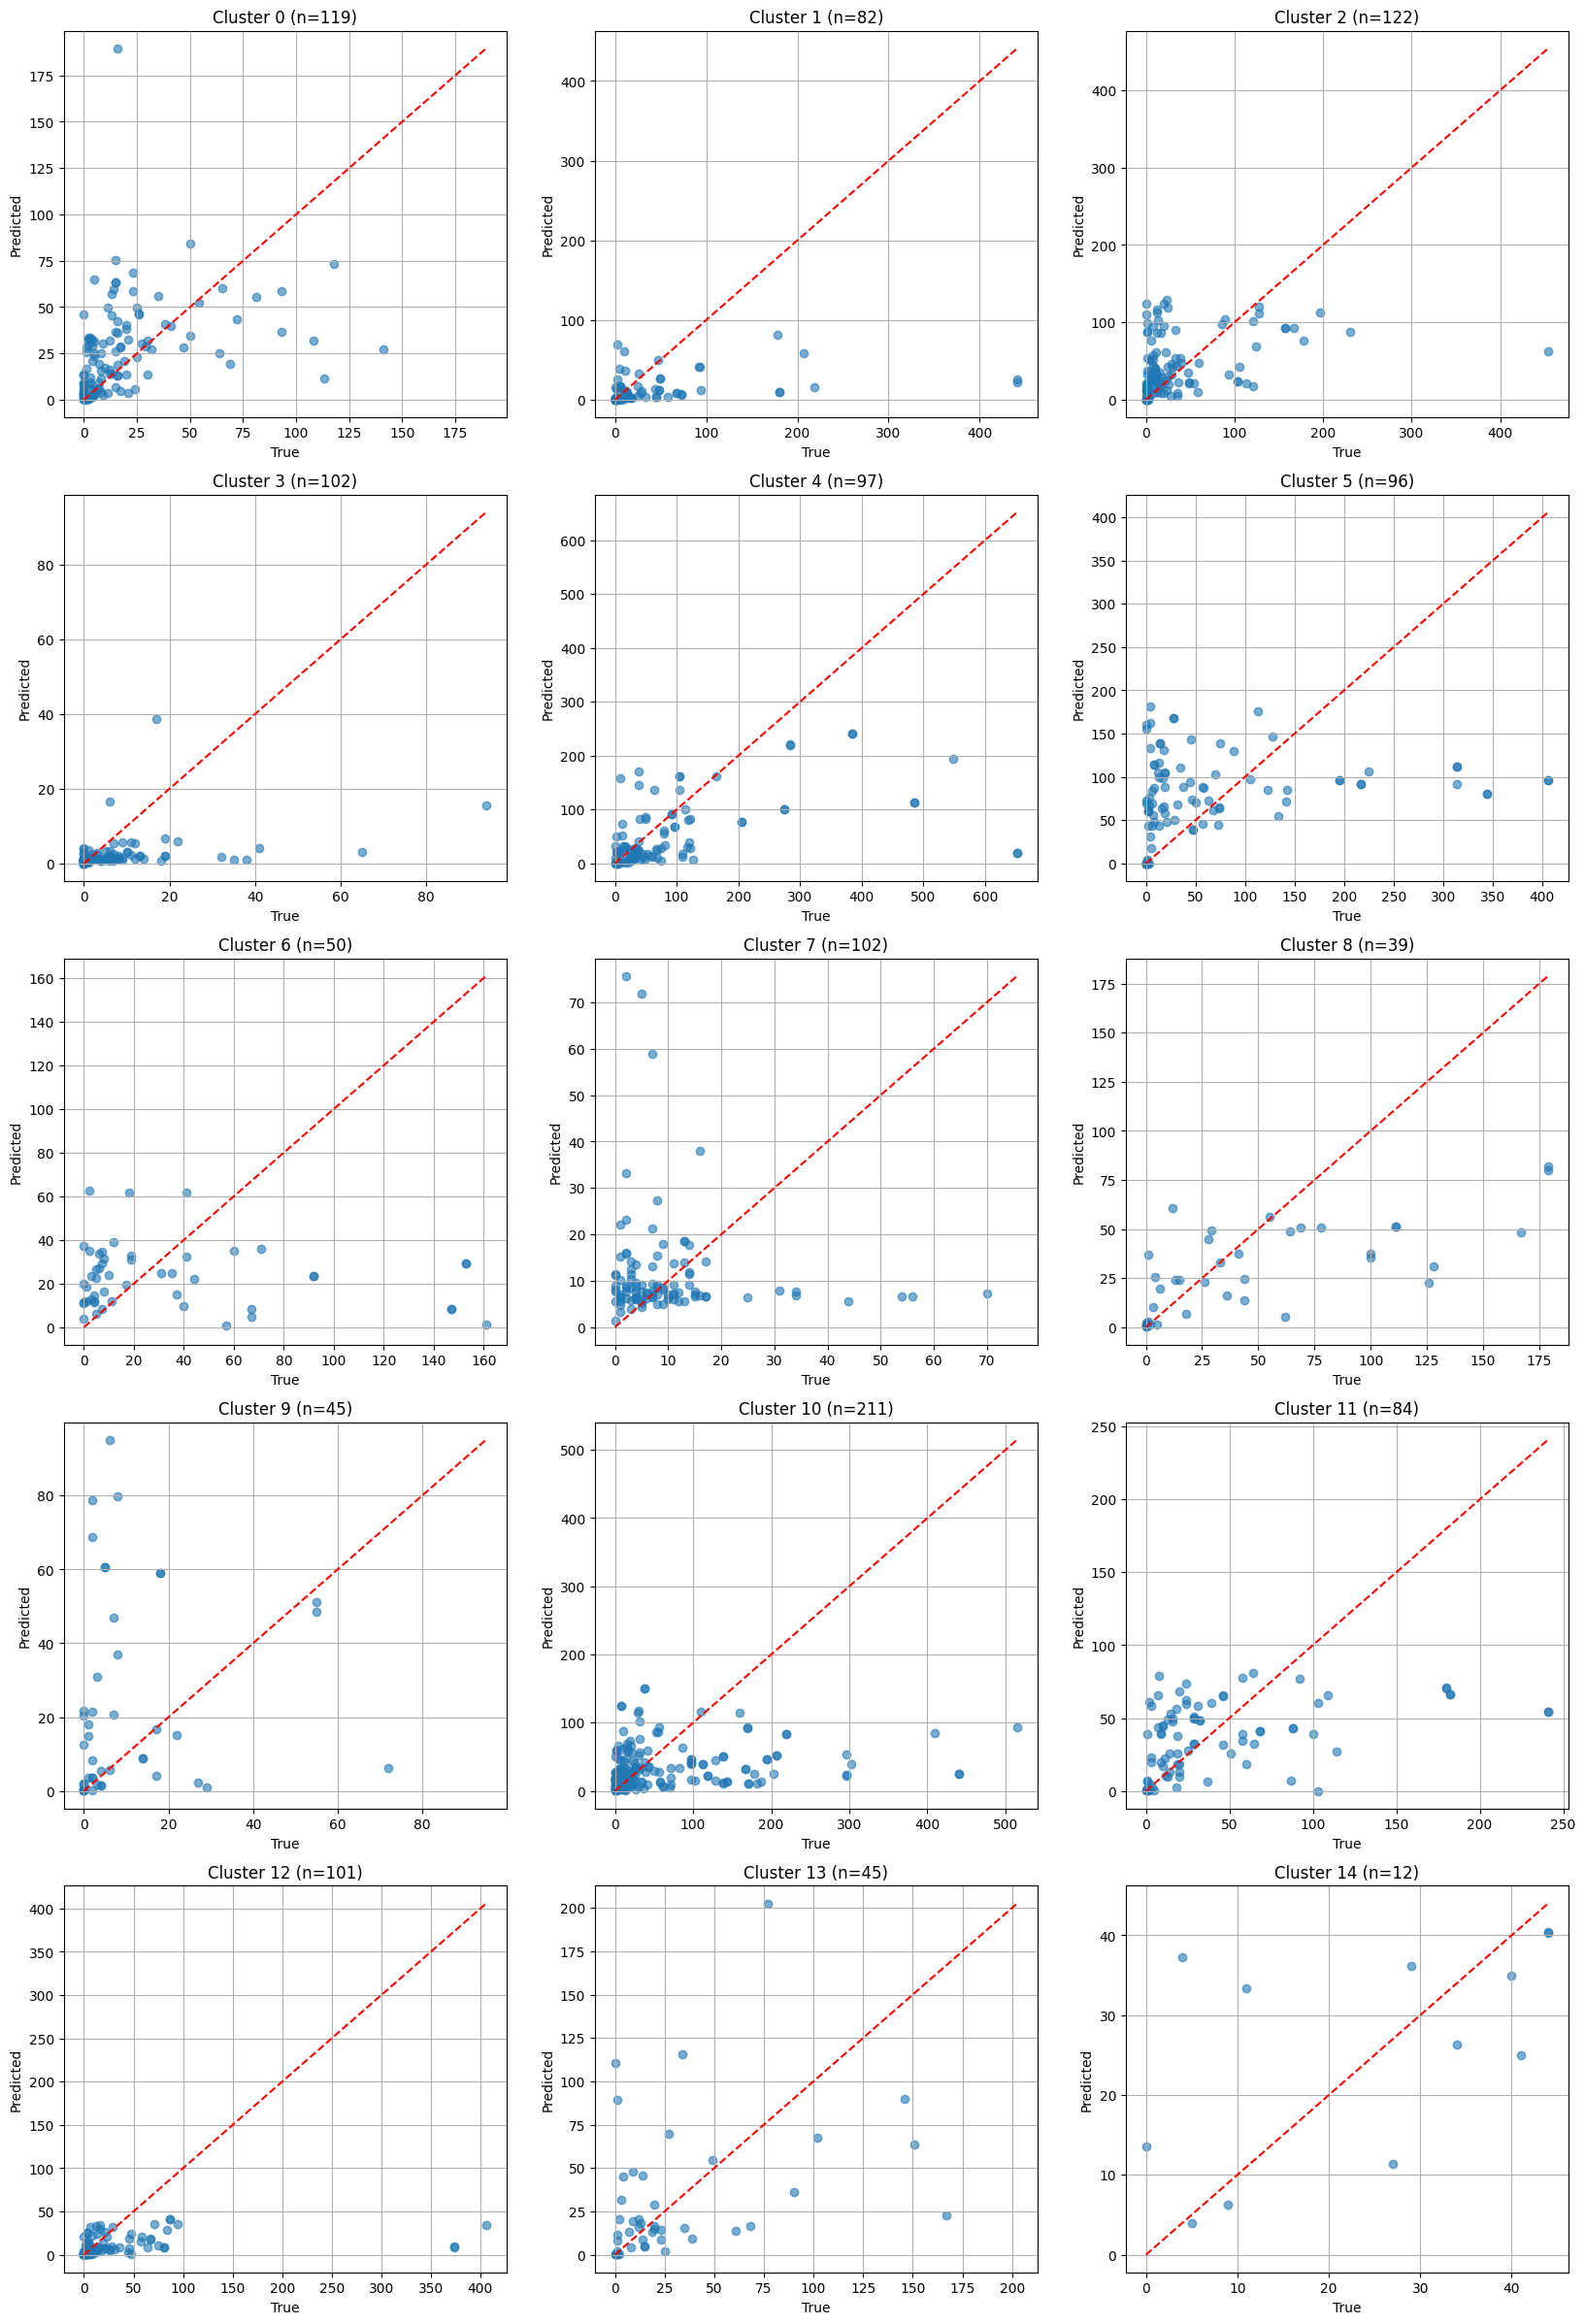

In [71]:
import matplotlib.pyplot as plt

# Group predictions and true values by cluster
projected_val = umap_model.transform(bert_val)
cluster_ids = np.argmin(np.linalg.norm(projected_val[:, None] - centroids[None], axis=2), axis=1)
true_vals = np.array([a['n_comments'] for a in val_articles])

# Plot predictions vs true values per cluster
plt.figure(figsize=(20, 30))
for cluster_id in range(centroids.shape[0]):
    idxs = np.where(cluster_ids == cluster_id)[0]
    if len(idxs) == 0:
        continue
    plt.subplot(5, 3, cluster_id + 1)
    plt.scatter(true_vals[idxs], preds_val[idxs], alpha=0.6)
    plt.plot([0, max(true_vals[idxs].max(), preds_val[idxs].max())],
             [0, max(true_vals[idxs].max(), preds_val[idxs].max())],
             color='red', linestyle='--')
    plt.title(f"Cluster {cluster_id} (n={len(idxs)})")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(True)

plt.tight_layout()
plt.savefig("cluster_predictions/validation_scatter_per_cluster.png")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


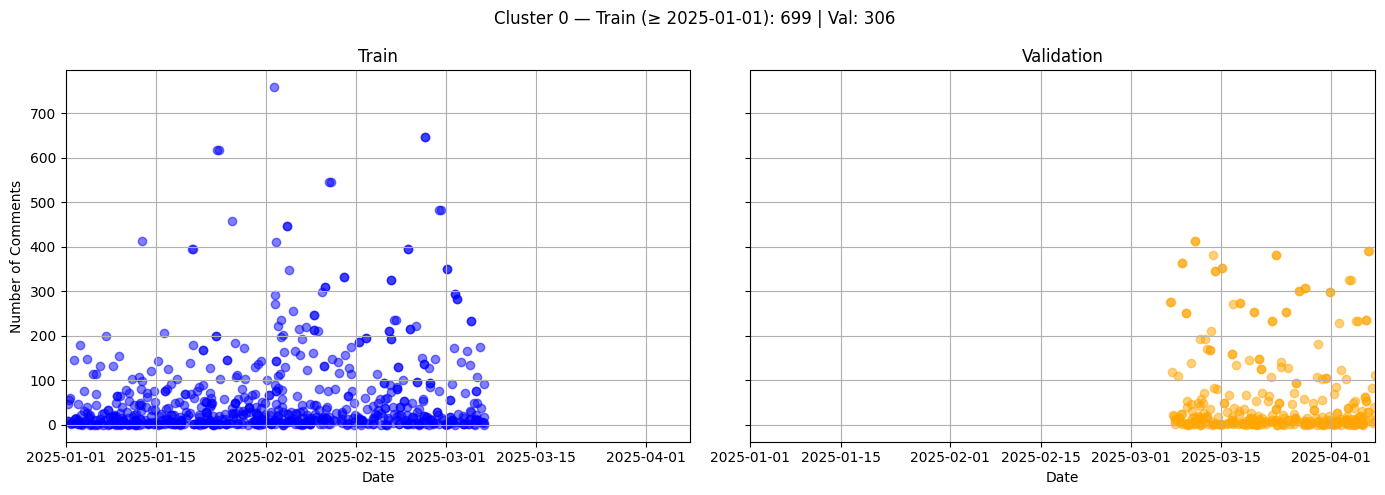

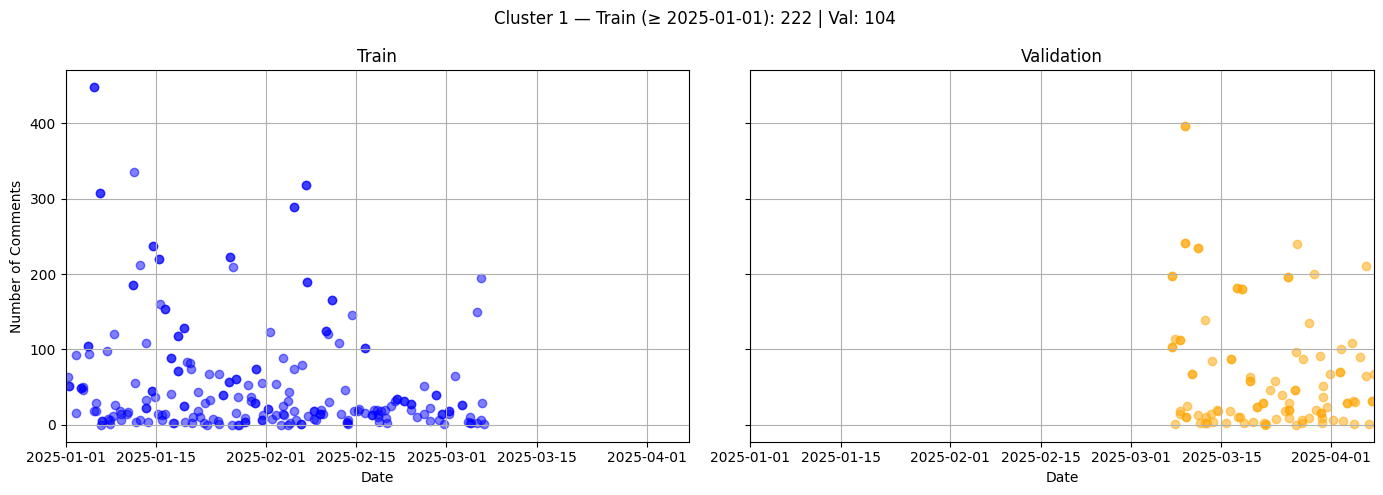

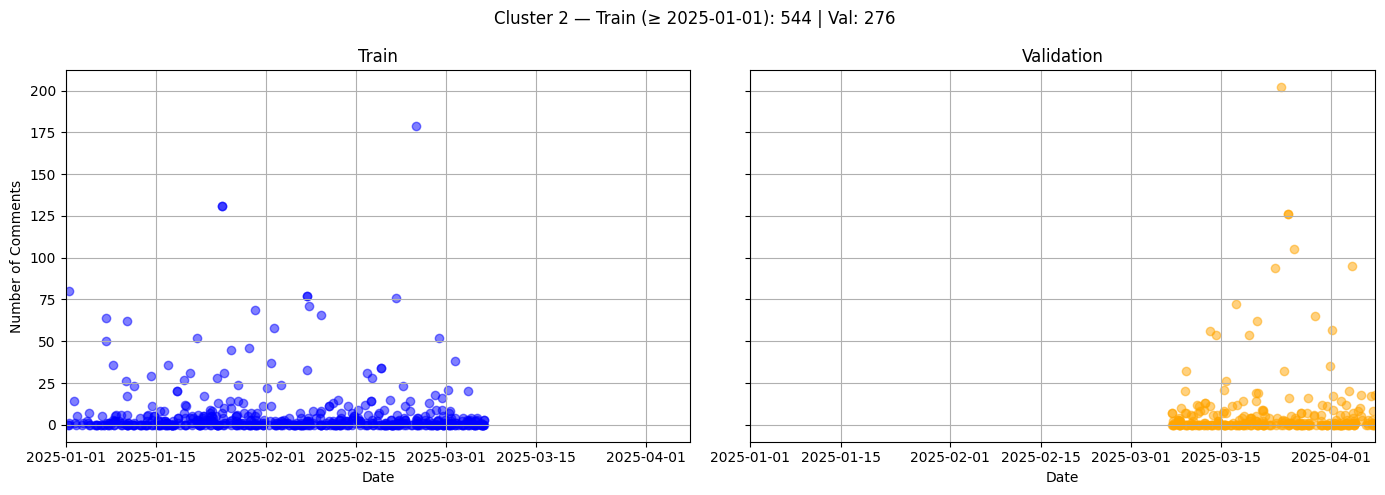

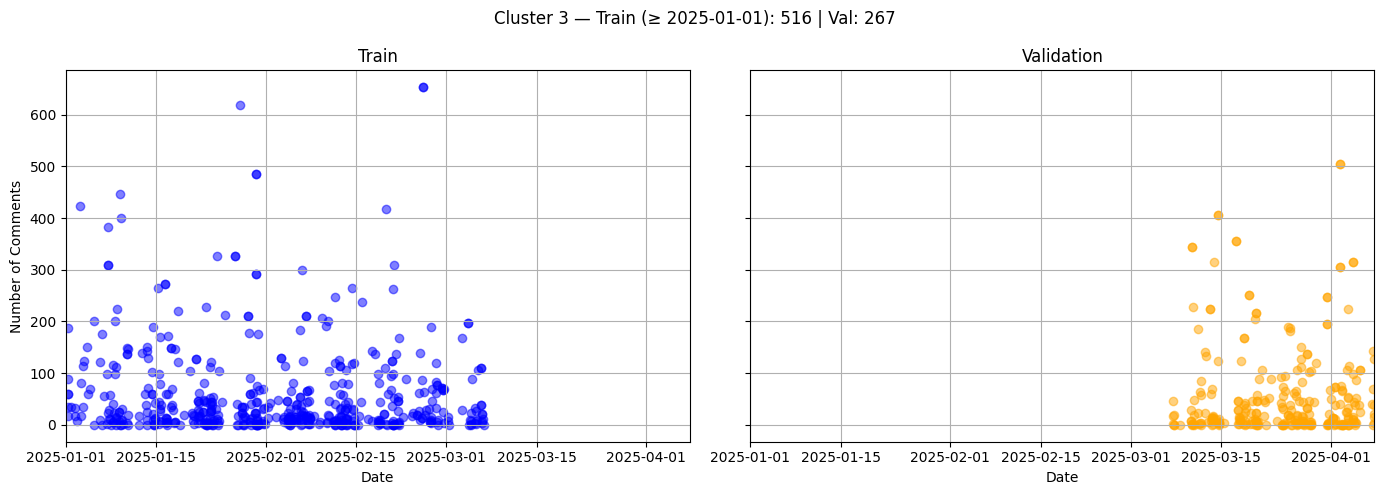

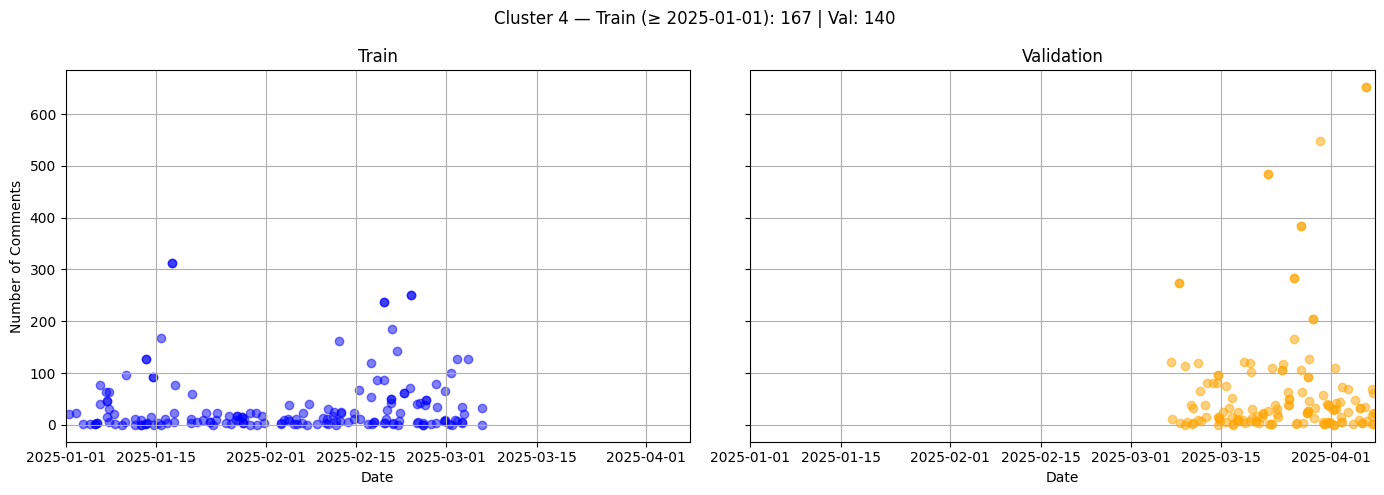

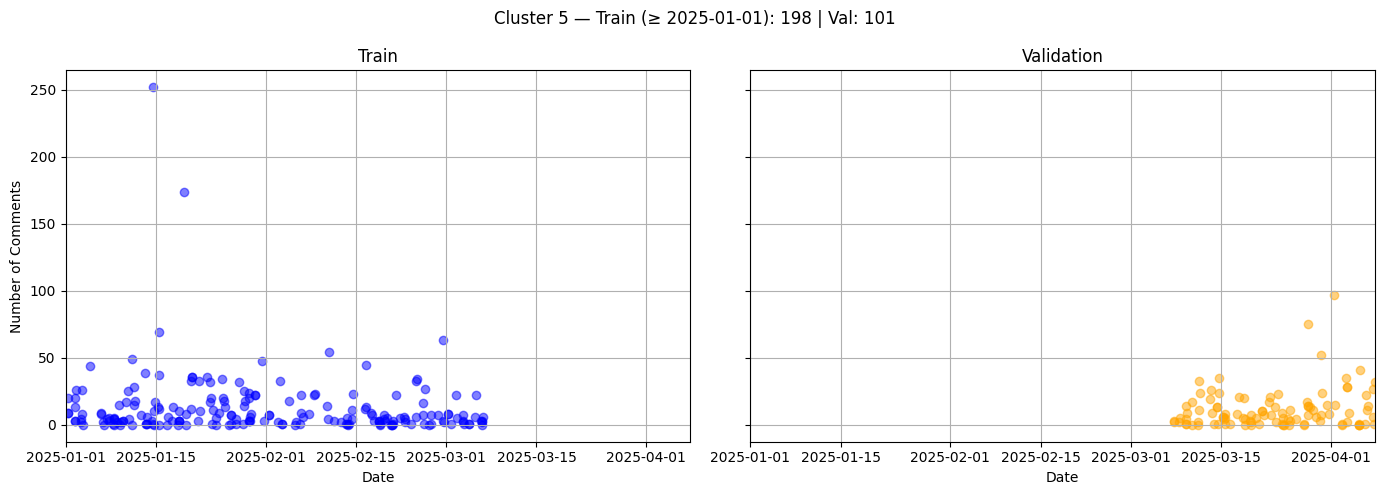

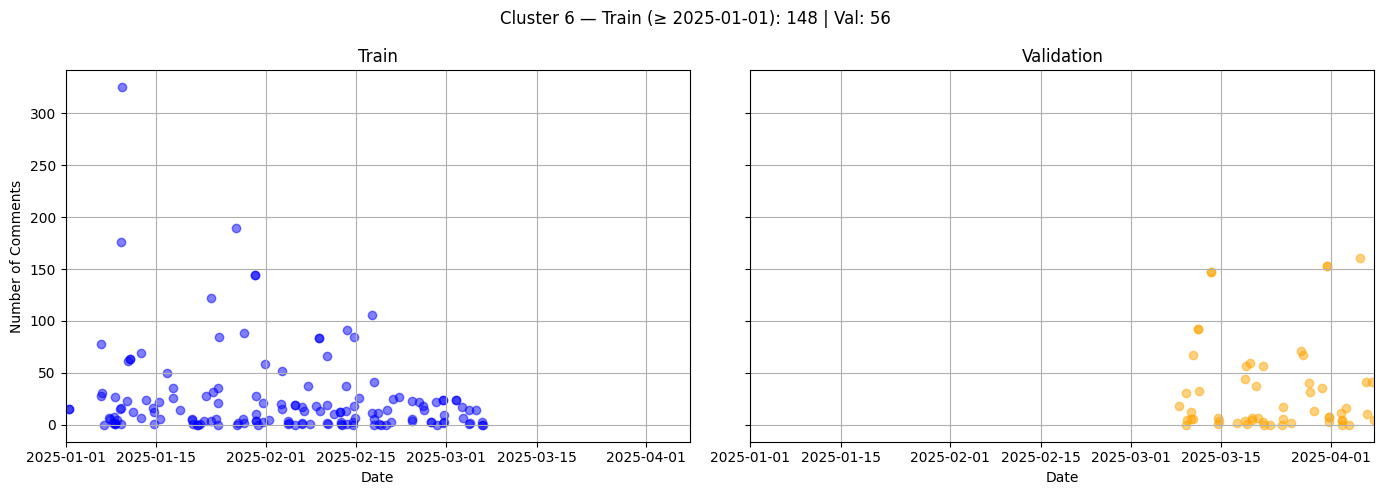

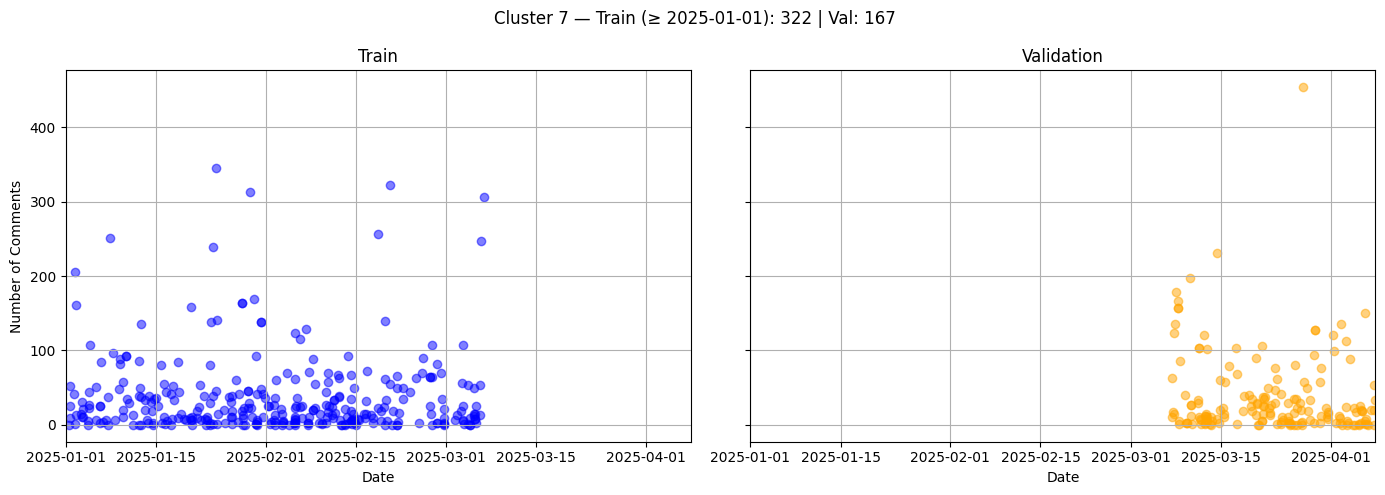

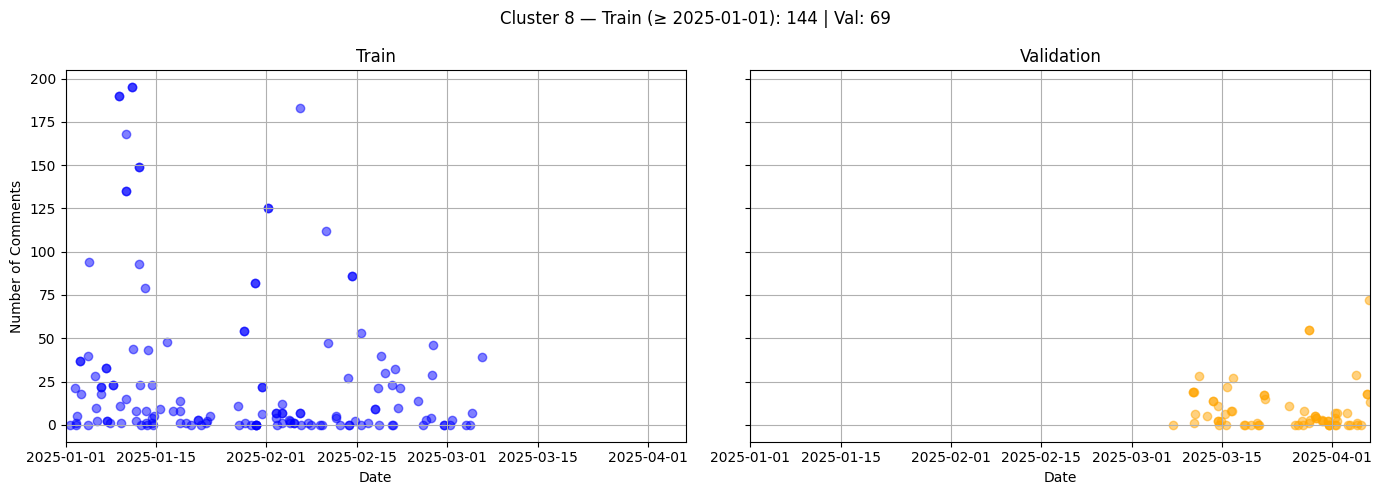

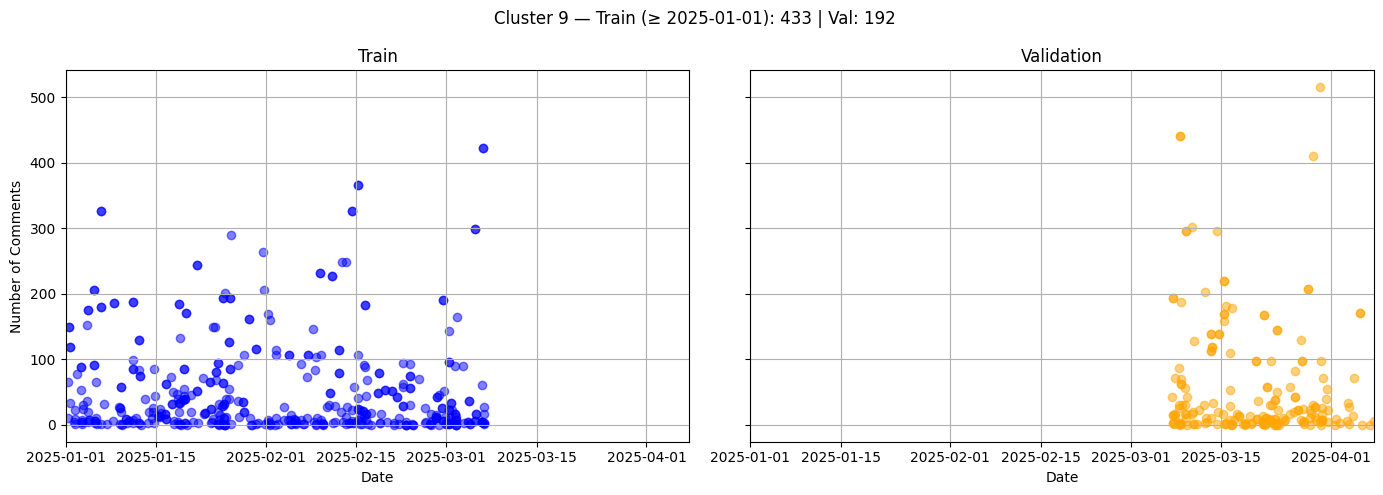

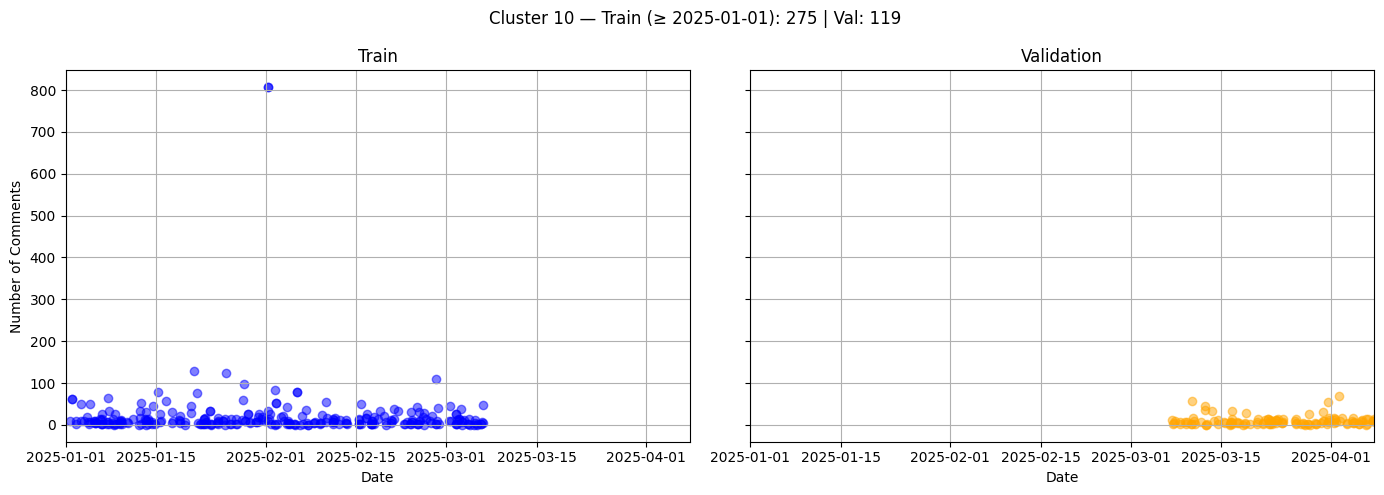

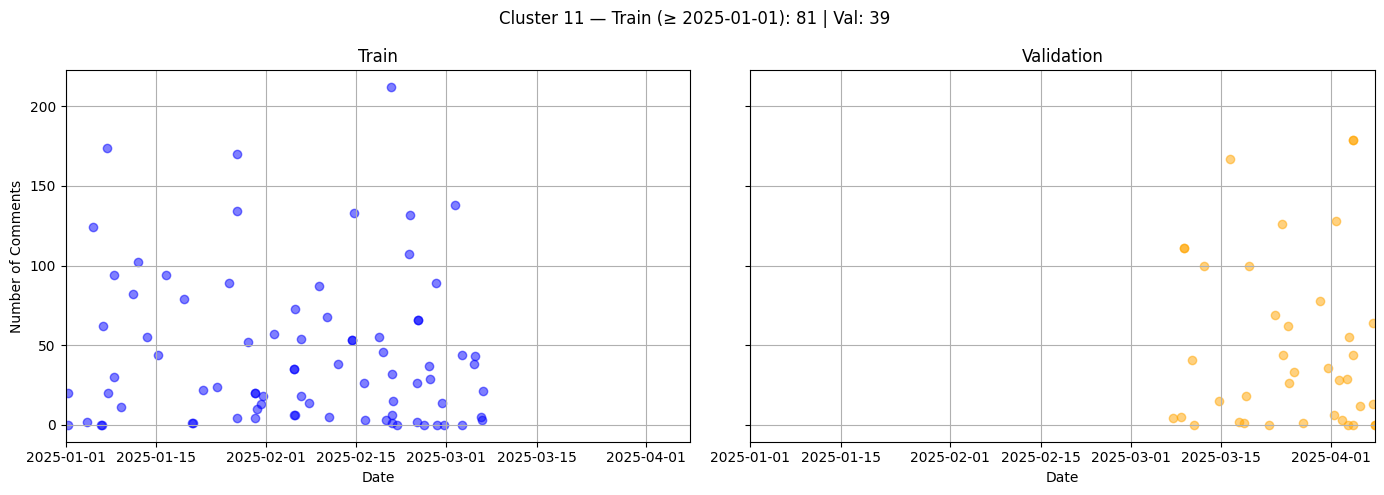

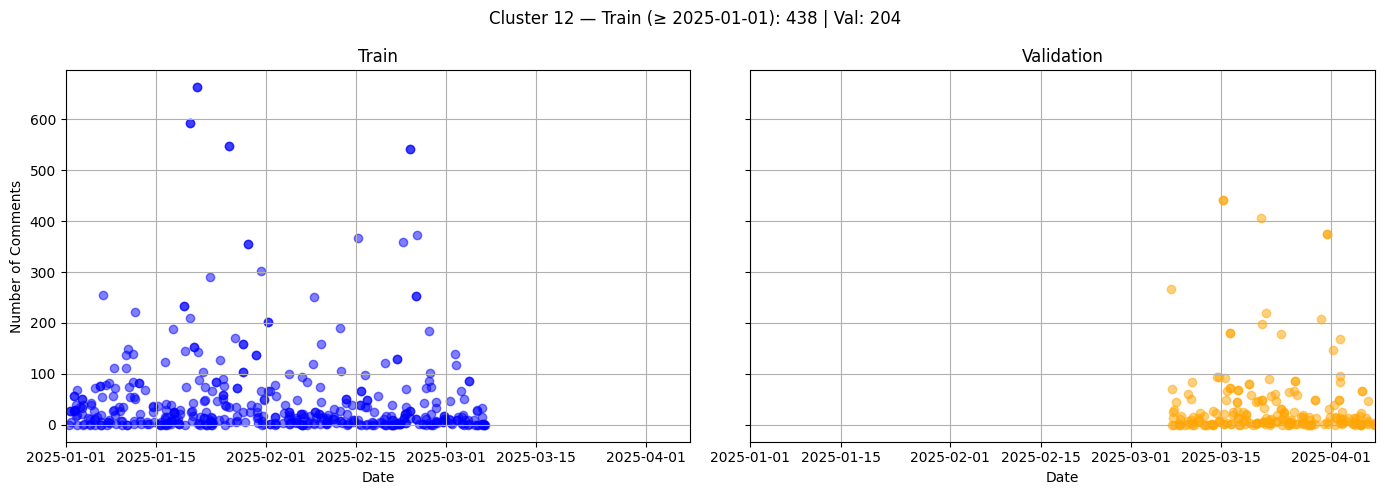

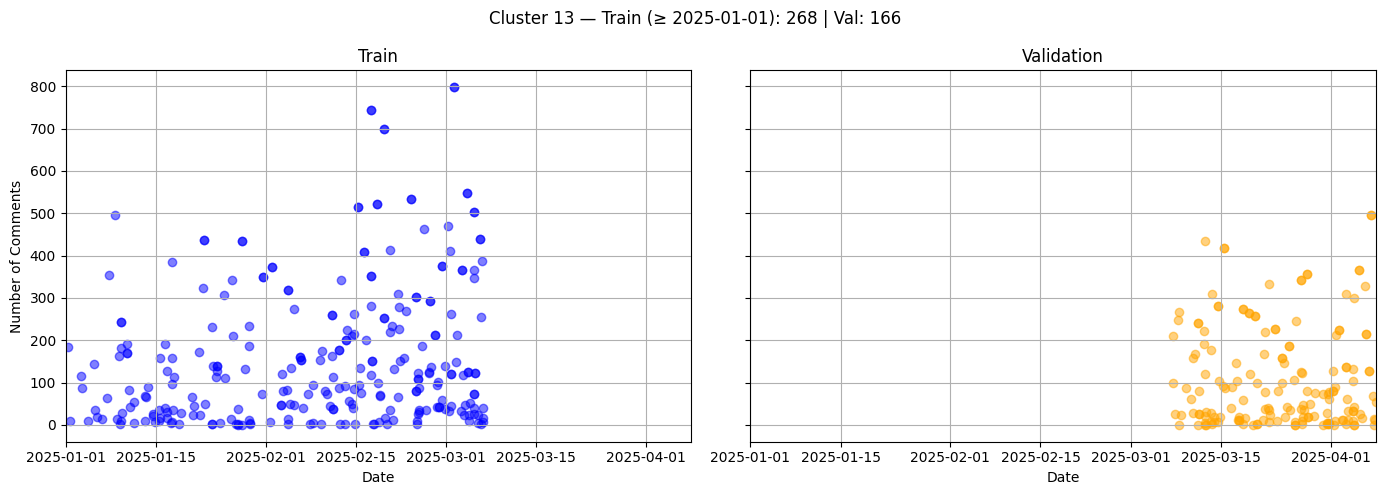

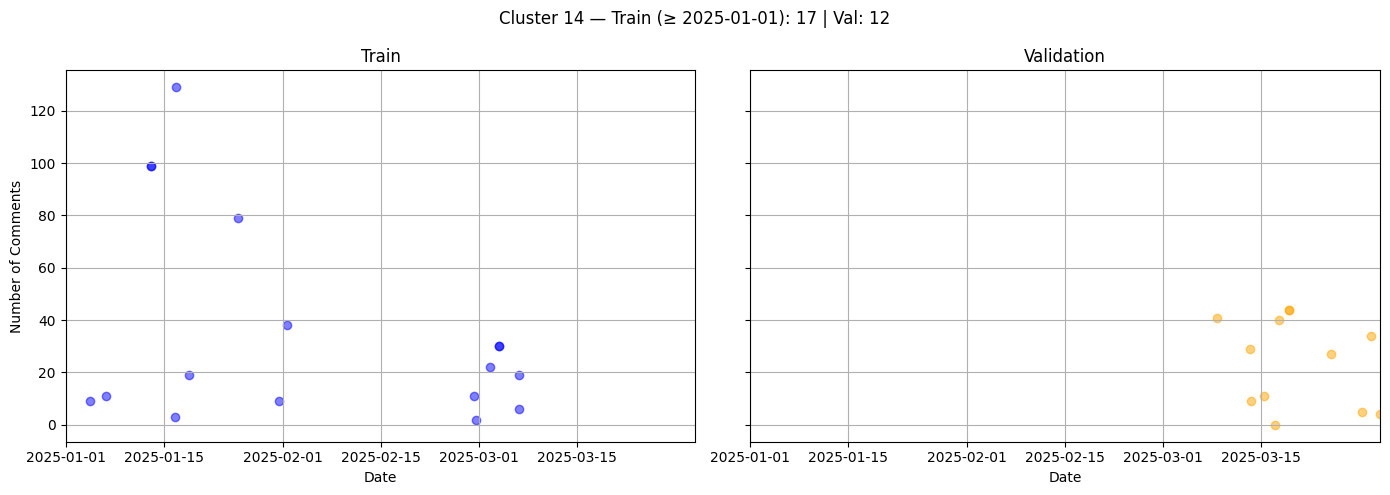

In [18]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import joblib

# === 1. Load models ===
umap_model = joblib.load("umap_model.pkl")
centroids = np.load("cluster_centroids.npy")

# === 2. Load embeddings ===
emb_train = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()
emb_val = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()

# === 3. Project with UMAP ===
proj_train = umap_model.transform(emb_train)
proj_val = umap_model.transform(emb_val)

# === 4. Assign clusters ===
def assign_clusters(projected, centroids):
    dists = np.linalg.norm(projected[:, None] - centroids[None], axis=2)
    return np.argmin(dists, axis=1)

train_labels = assign_clusters(proj_train, centroids)
val_labels = assign_clusters(proj_val, centroids)

# === 5. Load articles ===
with open("rtvslo_train.json", "r", encoding="utf-8") as f:
    articles_train = json.load(f)
with open("rtvslo_validation.json", "r", encoding="utf-8") as f:
    articles_val = json.load(f)

assert len(articles_train) == len(train_labels)
assert len(articles_val) == len(val_labels)

# === 6. Group by cluster ===
train_clusters = defaultdict(list)
val_clusters = defaultdict(list)

for article, label in zip(articles_train, train_labels):
    train_clusters[label].append(article)

for article, label in zip(articles_val, val_labels):
    val_clusters[label].append(article)

# === 7. Cutoff date = start of year of oldest val article
min_val_date = min(datetime.fromisoformat(a["date"]) for a in articles_val)
train_cutoff_date = datetime(min_val_date.year, 1, 1)

# === 8. Plot side-by-side per cluster
for cluster_id in sorted(set(train_clusters.keys()) | set(val_clusters.keys())):
    train_articles = [
        a for a in train_clusters.get(cluster_id, [])
        if datetime.fromisoformat(a["date"]) >= train_cutoff_date
    ]
    val_articles = val_clusters.get(cluster_id, [])

    train_dates = [datetime.fromisoformat(a["date"]) for a in train_articles]
    train_comments = [a["n_comments"] for a in train_articles]

    val_dates = [datetime.fromisoformat(a["date"]) for a in val_articles]
    val_comments = [a["n_comments"] for a in val_articles]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    fig.suptitle(f"Cluster {cluster_id} — Train (≥ {train_cutoff_date.date()}): {len(train_articles)} | Val: {len(val_articles)}")

    for ax, title, dates, comments, color in [
        (axes[0], "Train", train_dates, train_comments, "blue"),
        (axes[1], "Validation", val_dates, val_comments, "orange")
    ]:
        ax.scatter(dates, comments, alpha=0.5, color=color)
        ax.set_title(title)
        ax.set_xlabel("Date")
        ax.set_xlim(train_cutoff_date, max(train_dates + val_dates + [train_cutoff_date]))
        ax.grid(True)

    axes[0].set_ylabel("Number of Comments")
    plt.tight_layout()
    plt.show()


In [54]:
# --- 1. Imports ---
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import umap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# --- 2. Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 3. Utility Functions ---
def load_json(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def save_json(obj, fn):
    with open(fn, 'w', encoding='utf-8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    date_feats = np.concatenate([years_scaled, months_scaled, day_sin[:, None], day_cos[:, None], hour_sin[:, None], hour_cos[:, None]], axis=1)
    return date_feats

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

# --- 4. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, X, topic_ids, subtopic_ids, date_feats, targets=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.topic_ids = torch.tensor(topic_ids, dtype=torch.long)
        self.subtopic_ids = torch.tensor(subtopic_ids, dtype=torch.long)
        self.date_feats = torch.tensor(date_feats, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32) if targets is not None else None

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.y[idx]
        else:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx]

# --- 5. Model ---
class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)
        self.model = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats], dim=1)
        return self.model(x)

# --- 6. Cluster Trainer ---
def train_model_for_cluster(cluster_id, cluster_articles, bert_vectors, topic_encoder, subtopic_encoder, output_dir):
    print(f"\n🧠 Training cluster {cluster_id} with {len(cluster_articles)} articles")

    y_raw = np.array([a['n_comments'] for a in cluster_articles])
    y_log = np.log1p(y_raw)

    topic_ids = topic_encoder.transform([extract_topics_from_url(a['url'])[0] for a in cluster_articles])
    subtopic_ids = subtopic_encoder.transform([extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in cluster_articles])
    date_feats = process_date_features(cluster_articles)

    indices = [a['idx'] for a in cluster_articles]
    X = bert_vectors[indices]

    X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, y_train, y_val = train_test_split(
        X, topic_ids, subtopic_ids, date_feats, y_log, test_size=0.1, random_state=42
    )

    train_ds = NewsDataset(X_train, topic_train, subtopic_train, date_train, y_train)
    val_ds = NewsDataset(X_val, topic_val, subtopic_val, date_val, y_val)
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=64)

    model = MLPWithEmbeddings(X.shape[1], len(topic_encoder.classes_), len(subtopic_encoder.classes_)).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.HuberLoss()

    best_mae = float('inf')
    best_model = None
    patience_counter = 0
    patience_limit = 5

    for epoch in range(50):
        model.train()
        for xb, t, st, d, yb in train_dl:
            xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            y_pred = model(xb, t, st, d).squeeze()
            loss = criterion(y_pred, yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for xb, t, st, d, yb in val_dl:
                xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
                preds = model(xb, t, st, d).squeeze()
                val_preds.extend(torch.expm1(preds.cpu()).numpy())
                val_true.extend(torch.expm1(yb.cpu()).numpy())

        val_mae = mean_absolute_error(val_true, val_preds)
        print(f"Epoch {epoch+1:02d} - Cluster {cluster_id} - Val MAE: {val_mae:.2f}")

        if val_mae < best_mae:
            best_mae = val_mae
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    if best_model:
        model.load_state_dict(best_model)
        torch.save(model.state_dict(), os.path.join(output_dir, f"cluster_{cluster_id}_model.pt"))
        print(f"✅ Saved best model for cluster {cluster_id} (Val MAE: {best_mae:.2f})")

# --- 7. Prediction function ---
def predict(articles, bert_vectors, topic_encoder, subtopic_encoder, umap_model, centroids, model_dir):
    preds = np.zeros(len(articles))

    for a in articles:
        dt = pd.to_datetime(a['date'])
        a['year'] = dt.year
        a['month'] = dt.month
        a['day_of_week'] = dt.weekday()
        a['hour'] = dt.hour

    topics = []
    subtopics = []
    for a in articles:
        topic, subtopic = extract_topics_from_url(a['url'])
        topics.append(topic)
        subtopics.append(subtopic if subtopic != "NO_SUBTOPIC" else "none")

    date_feats = process_date_features(articles)

    topic_ids = [topic_encoder.classes_[0] if t not in topic_encoder.classes_ else t for t in topics]
    subtopic_ids = [subtopic_encoder.classes_[0] if s not in subtopic_encoder.classes_ else s for s in subtopics]
    topic_ids = topic_encoder.transform(topic_ids)
    subtopic_ids = subtopic_encoder.transform(subtopic_ids)

    # Project with UMAP
    projected = umap_model.transform(bert_vectors)
    dists = np.linalg.norm(projected[:, None] - centroids[None], axis=2)
    cluster_assignments = np.argmin(dists, axis=1)

    for cluster_id in range(centroids.shape[0]):
        idxs = np.where(cluster_assignments == cluster_id)[0]
        if len(idxs) == 0:
            continue

        X = bert_vectors[idxs]
        t_ids = topic_ids[idxs]
        st_ids = subtopic_ids[idxs]
        d_feats = date_feats[idxs]

        dataset = NewsDataset(X, t_ids, st_ids, d_feats)
        dataloader = DataLoader(dataset, batch_size=64)

        model = MLPWithEmbeddings(
            input_dim=X.shape[1],
            num_topics=len(topic_encoder.classes_),
            num_subtopics=len(subtopic_encoder.classes_)
        )
        model.load_state_dict(torch.load(f"{model_dir}/cluster_{cluster_id}_model.pt", map_location="cpu"))
        model.to(DEVICE)
        model.eval()

        cluster_preds = []
        with torch.no_grad():
            for xb, t, st, d in dataloader:
                xb, t, st, d = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE)
                out = model(xb, t, st, d).squeeze()
                cluster_preds.append(torch.expm1(out).cpu().numpy().reshape(-1))

        preds[idxs] = np.concatenate(cluster_preds)

    return np.clip(preds, 0, None)

# --- 8. Main ---
if __name__ == "__main__":
    os.makedirs("cluster_models", exist_ok=True)
    os.makedirs("cluster_predictions", exist_ok=True)

    # Load articles
    train_articles = load_json("rtvslo_train.json")
    val_articles = load_json("rtvslo_validation.json")

    # Load embeddings
    bert_train = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()
    bert_val = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()

    # Preprocess train
    for a in train_articles:
        dt = pd.to_datetime(a['date'])
        a['year'] = dt.year
        a['month'] = dt.month
        a['day_of_week'] = dt.weekday()
        a['hour'] = dt.hour

    # Build topic encoders
    topics = []
    subtopics = []
    for a in train_articles:
        topic, subtopic = extract_topics_from_url(a['url'])
        topics.append(topic)
        subtopics.append(subtopic if subtopic != "NO_SUBTOPIC" else "none")

    topic_encoder = LabelEncoder().fit(topics)
    subtopic_encoder = LabelEncoder().fit(subtopics)

    # UMAP
    umap_model = umap.UMAP(n_components=50, random_state=42)
    projected_train = umap_model.fit_transform(bert_train)
    joblib.dump(umap_model, "umap_model.pkl")

    # KMeans
    kmeans = KMeans(n_clusters=15, random_state=42)
    cluster_labels = kmeans.fit_predict(projected_train)
    centroids = kmeans.cluster_centers_
    np.save("cluster_centroids.npy", centroids)

    # Assign clusters
    for idx, a in enumerate(train_articles):
        a["cluster"] = int(cluster_labels[idx])
        a["idx"] = idx

    save_json(train_articles, "articles_with_clusters.json")

    # Train
    for cluster_id in range(15):
        cluster_articles = [a for a in train_articles if a["cluster"] == cluster_id]
        if len(cluster_articles) < 30:
            print(f"⚠️ Skipping cluster {cluster_id} (too few articles)")
            continue
        train_model_for_cluster(
            cluster_id, cluster_articles,
            bert_train, topic_encoder, subtopic_encoder,
            output_dir="cluster_models"
        )

    # Predict
    p_val = predict(val_articles, bert_val, topic_encoder, subtopic_encoder, umap_model, centroids, "cluster_models")
    p_train = predict(train_articles, bert_train, topic_encoder, subtopic_encoder, umap_model, centroids, "cluster_models")

    np.savetxt("cluster_predictions/predictions_val.txt", p_val, fmt="%.4f")
    np.savetxt("cluster_predictions/predictions_train.txt", p_train, fmt="%.4f")

    print("✅ Finished clustering, training and prediction.")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



🧠 Training cluster 0 with 6118 articles
Epoch 01 - Cluster 0 - Val MAE: 32.83
Epoch 02 - Cluster 0 - Val MAE: 33.17
Epoch 03 - Cluster 0 - Val MAE: 32.17
Epoch 04 - Cluster 0 - Val MAE: 29.40
Epoch 05 - Cluster 0 - Val MAE: 29.64
Epoch 06 - Cluster 0 - Val MAE: 28.19
Epoch 07 - Cluster 0 - Val MAE: 31.14
Epoch 08 - Cluster 0 - Val MAE: 29.52
Epoch 09 - Cluster 0 - Val MAE: 27.24
Epoch 10 - Cluster 0 - Val MAE: 29.15
Epoch 11 - Cluster 0 - Val MAE: 26.08
Epoch 12 - Cluster 0 - Val MAE: 28.04
Epoch 13 - Cluster 0 - Val MAE: 26.46
Epoch 14 - Cluster 0 - Val MAE: 54.42
Epoch 15 - Cluster 0 - Val MAE: 29.50
Epoch 16 - Cluster 0 - Val MAE: 27.53
⏹️ Early stopping at epoch 16
✅ Saved best model for cluster 0 (Val MAE: 26.08)

🧠 Training cluster 1 with 2256 articles
Epoch 01 - Cluster 1 - Val MAE: 64.00
Epoch 02 - Cluster 1 - Val MAE: 45.32
Epoch 03 - Cluster 1 - Val MAE: 41.39
Epoch 04 - Cluster 1 - Val MAE: 42.57
Epoch 05 - Cluster 1 - Val MAE: 46.88
Epoch 06 - Cluster 1 - Val MAE: 54.75
Ep

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Finished clustering, training and prediction.


In [76]:
from sklearn.neighbors import KNeighborsRegressor

# --- 5. Main ---
if __name__ == '__main__':
    train = load("rtvslo_train.json")
    validation = load("rtvslo_validation.json")

    for a in train + validation:
        dt = pd.to_datetime(a['date'])
        a['year'] = dt.year
        a['month'] = dt.month
        a['day_of_week'] = dt.weekday()
        a['hour'] = dt.hour

    # Labels
    y_train = np.log1p([a["n_comments"] for a in train])  # log scale for smoother regression

    # Features
    topics_train = [extract_topics_from_url(a['url'])[0] for a in train]
    subtopics_train = [extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in train]
    topics_val = [extract_topics_from_url(a['url'])[0] for a in validation]
    subtopics_val = [extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in validation]

    # Encoders
    topic_encoder = LabelEncoder().fit(topics_train)
    subtopic_encoder = LabelEncoder().fit(subtopics_train)
    topic_train_ids = topic_encoder.transform(topics_train)
    topic_val_ids = [t if t in topic_encoder.classes_ else topic_encoder.classes_[0] for t in topics_val]
    topic_val_ids = topic_encoder.transform(topic_val_ids)

    subtopic_train_ids = subtopic_encoder.transform(subtopics_train)
    subtopic_val_ids = [s if s in subtopic_encoder.classes_ else subtopic_encoder.classes_[0] for s in subtopics_val]
    subtopic_val_ids = subtopic_encoder.transform(subtopic_val_ids)

    # Feature arrays
    bert_train = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()
    bert_val = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()

    date_train = process_date_features(train)
    date_val = process_date_features(validation)

    # Final concatenated features
    X_train = np.concatenate([bert_train,
                              topic_train_ids[:, None],
                              subtopic_train_ids[:, None],
                              date_train], axis=1)

    X_val = np.concatenate([bert_val,
                            topic_val_ids[:, None],
                            subtopic_val_ids[:, None],
                            date_val], axis=1)

    # --- Train KNN regressor ---
    knn = KNeighborsRegressor(n_neighbors=5, weights='distance', n_jobs=-1)
    knn.fit(X_train, y_train)

    # --- Predict and save ---
    y_pred_val = knn.predict(X_val)
    y_pred_val = np.clip(np.expm1(y_pred_val), 0, None)
    np.savetxt("predictions_val_knn.txt", y_pred_val, fmt="%.4f")
    print("✅ Saved predictions_val.txt")


✅ Saved predictions_val.txt
